<div style="border-radius: 10px; box-shadow: 0px 0px 2px; border: 1px solid; background:#eaeaea; position: relative; padding: 10px; padding-left: 10px;">
<h7 style="color:black; margin-bottom:20px"> 

# <span style="color:#143a51">Прогнозирование оттока клиентов сети фитнес-центров <span> 
    
---
---   
**Цель:** на основе данных клиентов сети фитнес-центров научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента, сформировать типичные портреты клиентов, проанализировать основные признаки, наиболее сильно влияющие на отток, сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами.
    
--- 
    
**Описание данных**
    
`gender` — пол    
`Near_Location` — проживание или работа в районе, где находится фитнес-центр     
`Partner` — сотрудник компании-партнёра клуба    
`Promo_friends` — факт первоначальной записи в рамках акции «приведи друга»     
`Phone` — наличие контактного телефона     
`Age` — возраст     
`Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах)     
`Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год)    
`Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах)     
`Group_visits` — факт посещения групповых занятий     
`Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента     
`Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц     
`Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон    
`Churn` — факт оттока в текущем месяце.
    

## Открытие данных
<a id="start"></a>

In [1]:
# импоритируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.metrics import silhouette_score

# устанавливаем параметры отображение 
pd.options.display.max_columns = 40 


In [2]:
# считаем данные и сохраним в переменную df
df = pd.read_csv('/datasets/gym_churn.csv')


In [3]:
# создадим функцию start, которая будет выводить основную информацию по датафрейму
def start(df):
    display(df.head())
    print(df.info())
    print()
    print('Размер таблицы:', df.shape)
    print()
    print('Количество пропусков:', df.isna().sum(), sep='\n')
    print()
    print('Наличие дубликатов:', df.duplicated().sum())

In [4]:
# вызовем функцию start 
start(df)

gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0         3                   0.020398                           0.000000   
1         7                   1.922936                           1.910244   
2         2                   1.859098                           1.736502   
3         2                   3.205633                           3.357215   
4         3                   1.113884                           1.120078   

   Churn  
0      0  
1      0  
2      0  
3      0  
4      0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
# приведем названия столбцов к нижнему регистру
df.columns = [col.lower() for col in df.columns]
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

**Вывод:** датафрейм содержит 4000 строк и 14 столбцов. Пропусков и дубликатов не выявлено.   
Целевая переменная: `churn` – признак оттока, где 1 – потеря клиента. 

## Исследовательский анализ данных (EDA)
<a id="preprocessing"></a>

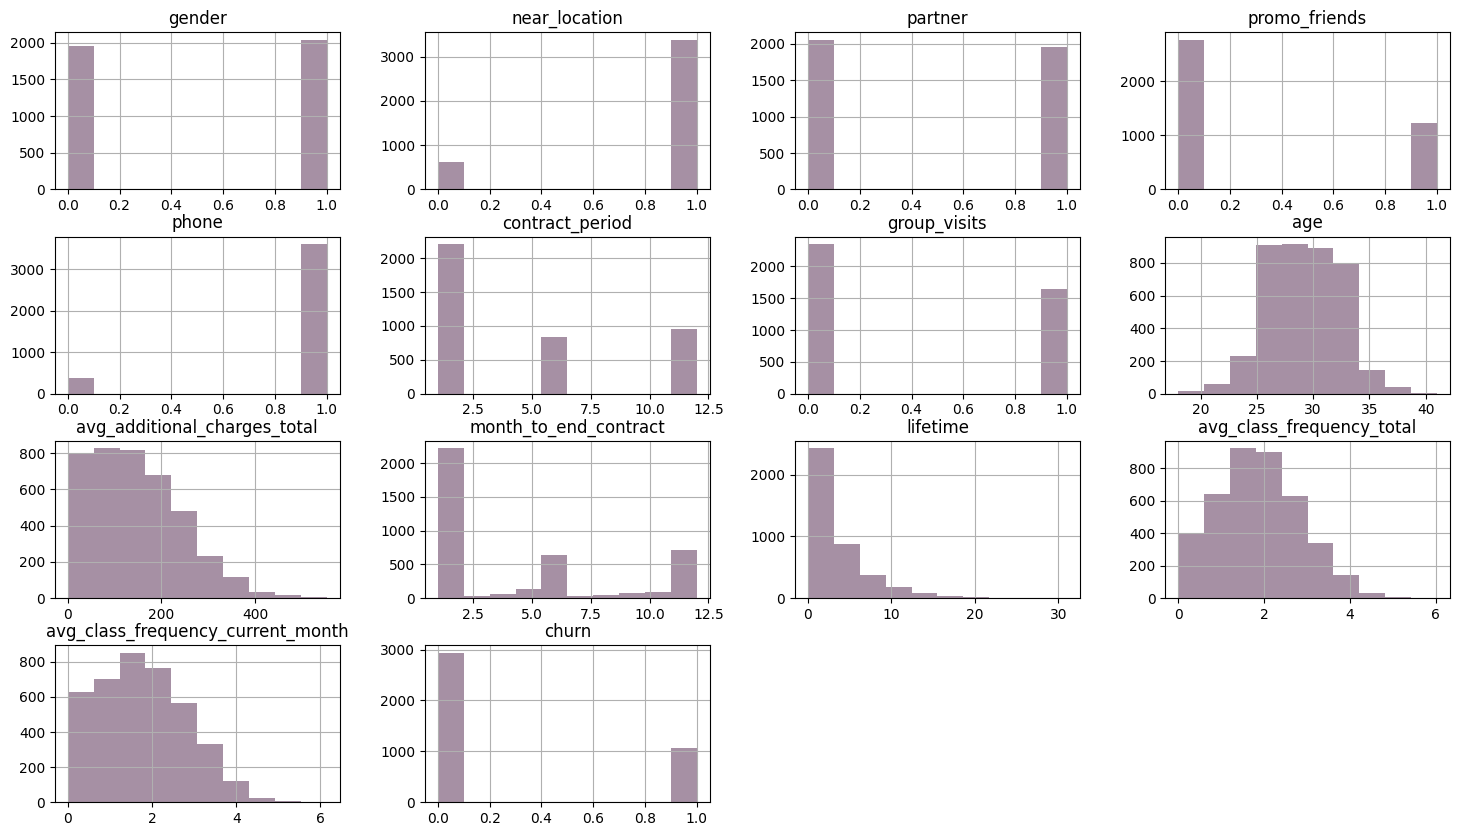

In [6]:
# построим общую гистограмму для всех числовых столбцов таблицы
color = ['#A690A4', '#FCD0A1']
df.hist(figsize=(18,10), color = color[0]);

In [7]:
# применим метод describe() 
df.describe().round(3).T

count     mean     std     min     25%  \
gender                             4000.0    0.510   0.500   0.000   0.000   
near_location                      4000.0    0.845   0.362   0.000   1.000   
partner                            4000.0    0.487   0.500   0.000   0.000   
promo_friends                      4000.0    0.308   0.462   0.000   0.000   
phone                              4000.0    0.904   0.295   0.000   1.000   
contract_period                    4000.0    4.681   4.550   1.000   1.000   
group_visits                       4000.0    0.412   0.492   0.000   0.000   
age                                4000.0   29.184   3.258  18.000  27.000   
avg_additional_charges_total       4000.0  146.944  96.356   0.148  68.869   
month_to_end_contract              4000.0    4.323   4.191   1.000   1.000   
lifetime                           4000.0    3.725   3.749   0.000   1.000   
avg_class_frequency_total          4000.0    1.879   0.972   0.000   1.181   
avg_class_frequency_current_month  4000.0    1.767   1.053   0.000   0.963   
churn                              4000.0    0.265   0.442   0.000   0.000   

                                       50%      75%      max  
gender                               1.000    1.000    1.000  
near_location                        1.000    1.000    1.000  
partner                              0.000    1.000    1.000  
promo_friends                        0.000    1.000    1.000  
phone                                1.000    1.000    1.000  
contract_period                      1.000    6.000   12.000  
group_visits                         0.000    1.000    1.000  
age                                 29.000   31.000   41.000  
avg_additional_charges_total       136.220  210.950  552.591  
month_to_end_contract                1.000    6.000   12.000  
lifetime                             3.000    5.000   31.000  
avg_class_frequency_total            1.833    2.536    6.024  
avg_class_frequency_current_month    1.720    2.510    6.147  
churn                                0.000    1.000    1.000

- Доля оттока составляет 26.5% 
- Доля оттока дополнительного говорит о дисбалансе классов в целевом признаке
- Доли мужчин и женщин среди клиентов примерно равны
- Разброс возраста клиентов составляет от 18 до 41 лет, средний возраст - 29 лет
- Почти 85% проживают рядом с фитнес-клубом
- Есть 10% клиентов, которые не указывают свой номер телефона
- Почти половина клиентов (48.7%) являются сотрудниками компаний-партнеров
- 31% использовали промо-код от знакомого при оплате первого абонемента
- 41% посещают групповые занятия
- У большей половины клиентов имеют контракт всего на 1 месяц и до окончания контракта тоже 1 месяц
- Средний лайфтайм составляет около 4 мес, при этом максимальное значение доходит до 31 месяца, на гистограмме видно, что есть выбросы
- Распределение среднего посещений за всё время и в последний месяц схожи, среднее значение составляет около 2-х занятий в неделю. Есть клиенты, которые еще не посещали фитнес, а есть те, кто ходит 6 раз в неделю
- Средний доход от дополнительных услуг - 147 руб, только у 25% клиентов суммарная выручка составила свыше 210 руб



In [8]:
# создадим функцию для отображения значений на графиках
def signature(chart, n):
    for p in chart.patches:
             chart.annotate(n %  p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')

contract_period
1              55.0
12             24.0
6              21.0

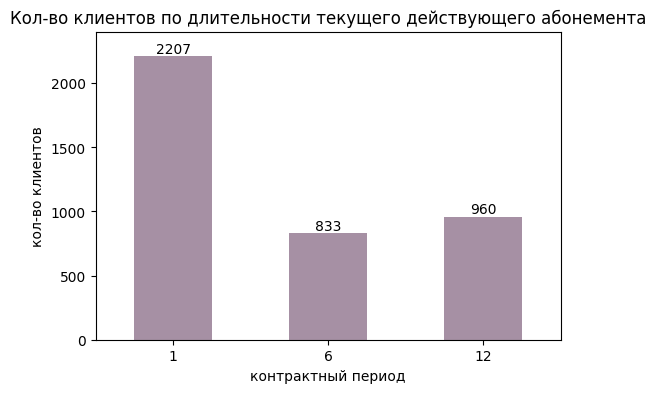

In [9]:
# посмотрим на распределение кол-ва клиентов по сроку контракта
display(df['contract_period'].value_counts(normalize=True).round(2).to_frame() * 100)
chart = df['contract_period'].value_counts().sort_index().plot(kind='bar', 
                                    rot=0, 
                                    figsize=(6,4), 
                                    color = color[0])
plt.ylim(0, 2400)
plt.ylabel('кол-во клиентов')
plt.xlabel('контрактный период')
plt.title("Кол-во клиентов по длительности текущего действующего абонемента")
signature(chart, "%.0f");

55% клиентов имеют контракты всего на 1 месяц

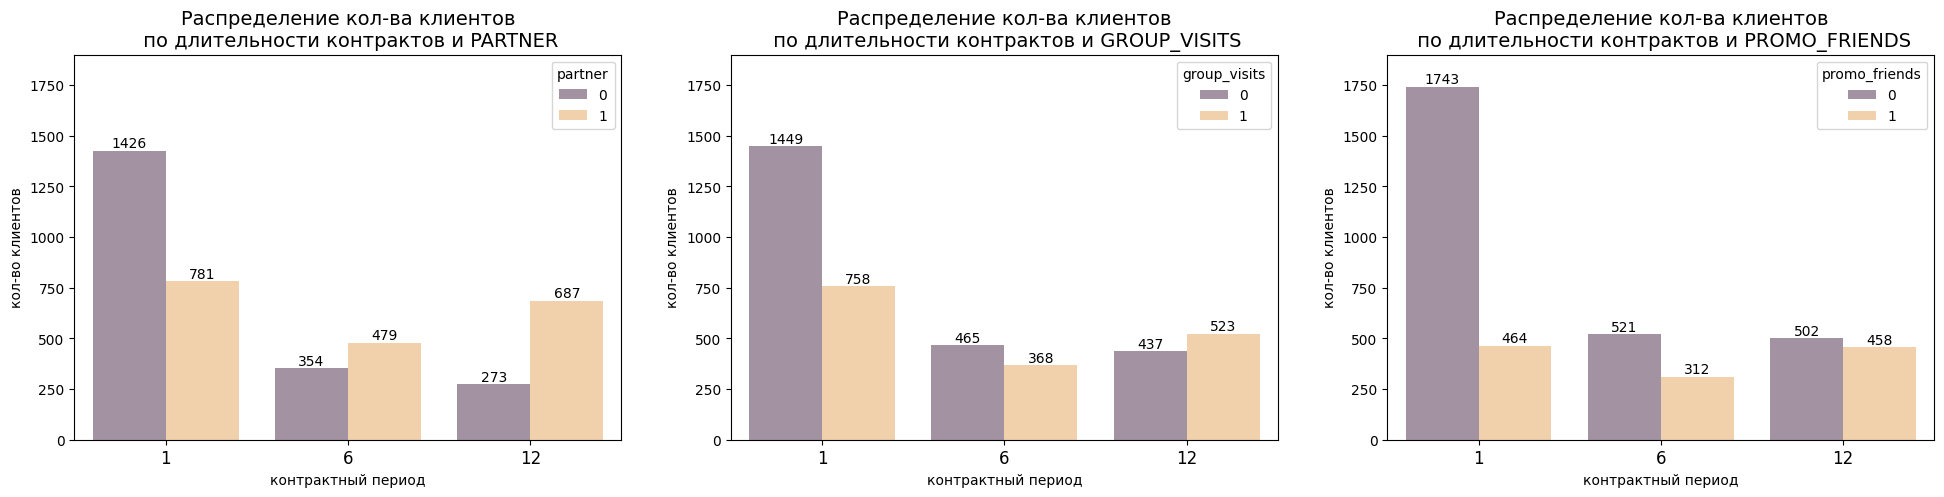

In [10]:
# посмотрим на распределение кол-ва клиентов по сроку контракта и таких признаков как партнерство, групповые занятия и промокод
fig, ax = plt.subplots(figsize = (24, 5))
for num, col in enumerate(['partner', 'group_visits', 'promo_friends']):
    chart = sns.countplot(x= 'contract_period', hue= col, data=df, palette= color, ax = plt.subplot(1, 3, num+1))
    plt.ylim(0, 1900)
    plt.xticks(fontsize='12')
    plt.ylabel('кол-во клиентов')
    plt.xlabel('контрактный период')
    plt.title('Распределение кол-ва клиентов\n по длительности контрактов и '+ col.upper(), fontsize='14')
    signature(chart, "%.0f")
plt.show()

- Видно, что корпоративные клиенты чаще заключают контракты на более длительный срок и их доля значительно превалирует (около 70%) среди контрактов на год.
- Бльшинство клиентов с конрактом на год посещают групповые занятия.
- Почти половина клиентов с контрактом на год пришли по промокоду.

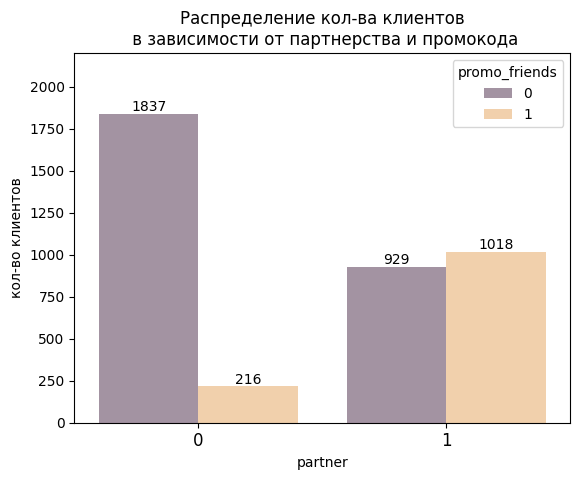

In [11]:
# посмотрим на распределение кол-ва клиентов среди компаний- партнеров и использования промокода
chart = sns.countplot(x = 'partner', hue = 'promo_friends', data = df, palette = color)
plt.ylim(0, 2200)
plt.xticks(fontsize='12')
plt.ylabel('кол-во клиентов')

plt.title('Распределение кол-ва клиентов\n в зависимости от партнерства и промокода')
signature(chart, "%.0f")
plt.show()

Большинство клиентов, пришедших по промокоду являются сотрудниками компаний-партнеров. Так как доля таких клиетов от общего числа  составляет 25%, возможно стоит уточнить, каковы правила выдачи скидки у данных клиентов.

**`Посмотрим на данные для ушедших и оставшихся клиентов`**

In [12]:
# применим метод groupby() для столбца 'churn' и посчитаем среднее хначения для признаков
df.groupby('churn').agg('mean').round(2).T

churn                                   0       1
gender                               0.51    0.51
near_location                        0.87    0.77
partner                              0.53    0.36
promo_friends                        0.35    0.18
phone                                0.90    0.90
contract_period                      5.75    1.73
group_visits                         0.46    0.27
age                                 29.98   26.99
avg_additional_charges_total       158.45  115.08
month_to_end_contract                5.28    1.66
lifetime                             4.71    0.99
avg_class_frequency_total            2.02    1.47
avg_class_frequency_current_month    2.03    1.04

- Видно, что для признаков пол и телефон одинаковые значения в 2-х группах
- Для остальных признаков средние значения для клиентов, попавших в отток ниже, чем у не попавших
- для оттока характерно снижение кол-ва посещений в последний месяц

In [13]:
# создадим списки с названием столбцов для разных типов графиков, исключая 'churn'
# col_plot - бинарные признаки + 'contract_period'
col_plot = []
# col_hist -  все остальные 
col_hist = []
for col in df.drop('churn', axis=1).columns:
    if len(df[col].unique()) > 3:
        col_hist.append(col)
    else:
        col_plot.append(col)
print(col_hist)
print(col_plot)

['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']
['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits']


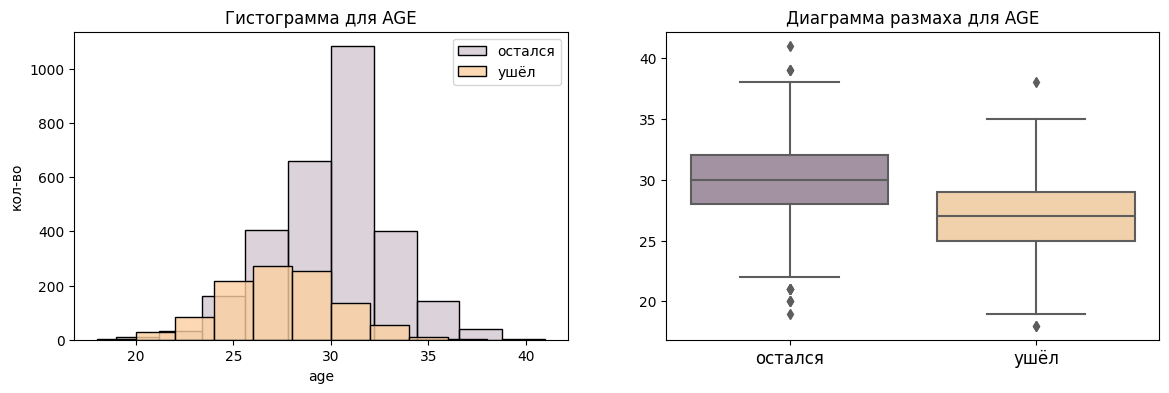

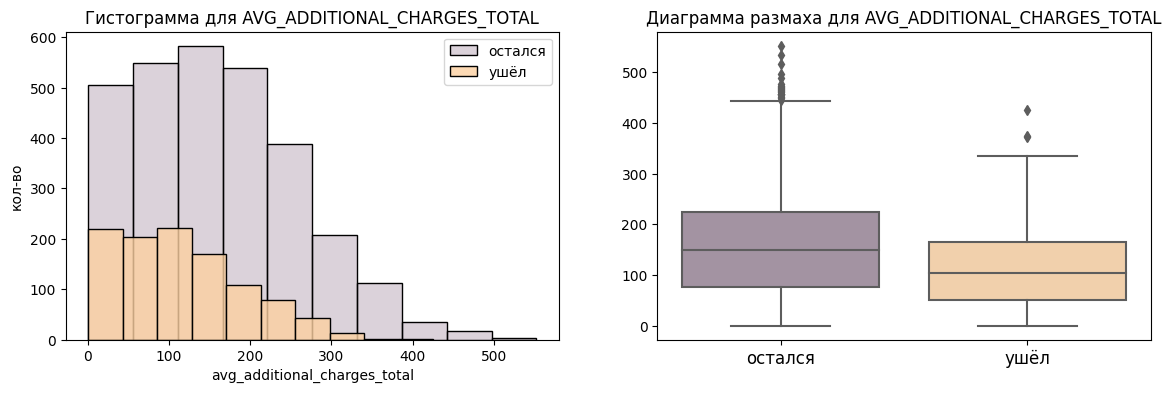

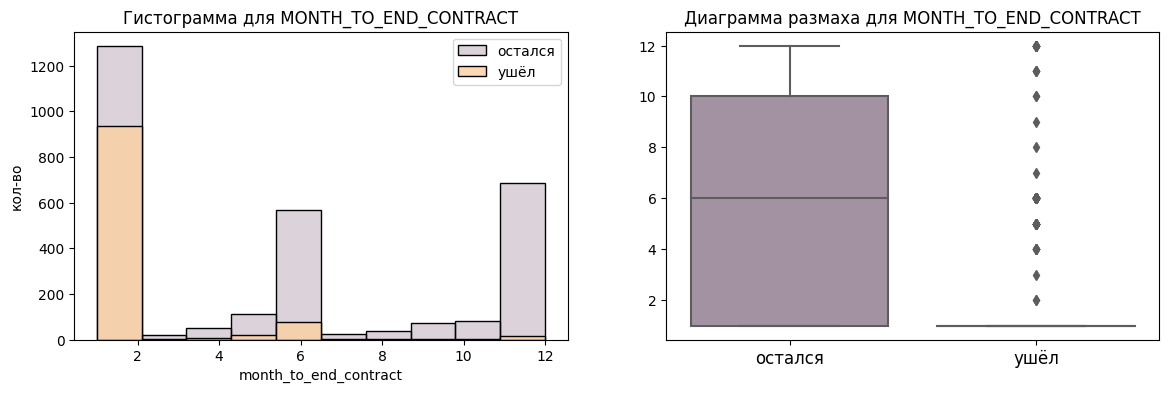

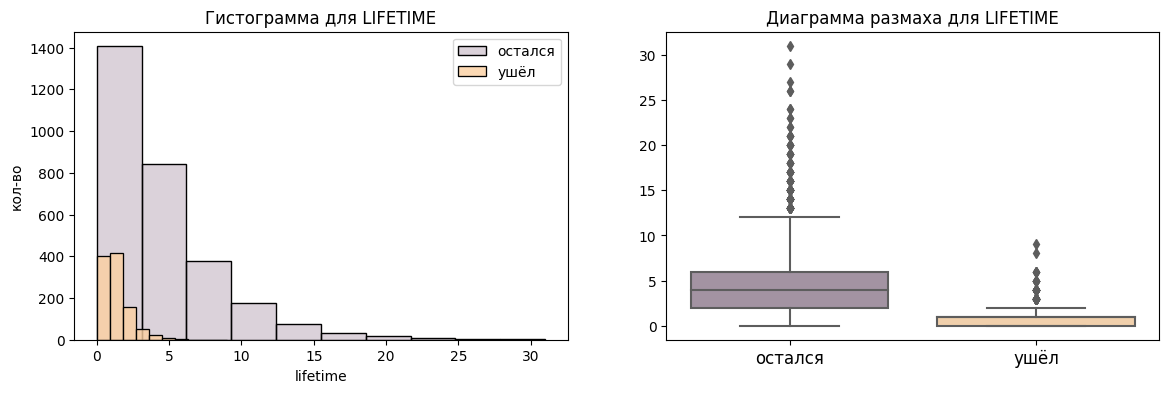

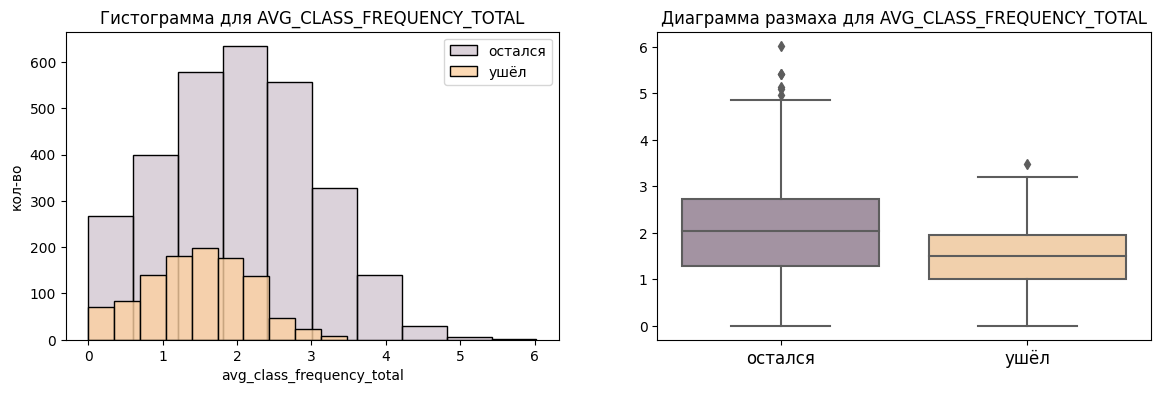

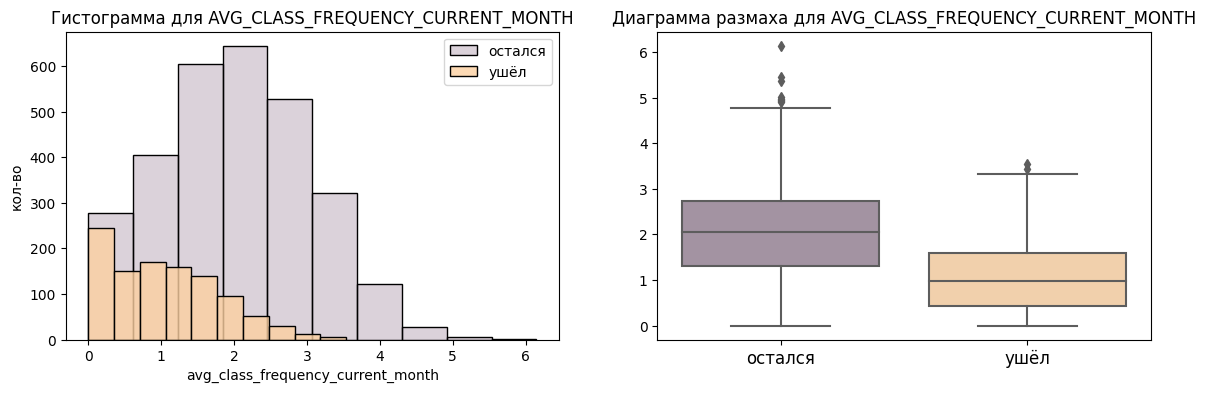

In [14]:
# построим гистограммы и боксплоты для следующих признаков
# возраста, суммарной выручки других услуг, кол-ва месяцев до окончания контракта, лайфтайма, средней частота посещений в неделю за все время и предыдущий месяц
for col in col_hist:
    plt.figure(figsize=(14, 4))

    ax1 = plt.subplot(1, 2, 1)
    sns.histplot(df[df['churn'] == 0], x= col, bins=10,
             color = color[0], alpha=0.4, label= 'остался', ax=ax1)
    sns.histplot(df[df['churn'] == 1], x= col, bins=10,
             color = color[1], alpha=0.8, label= 'ушёл', ax=ax1)
     
    plt.legend()
    plt.ylabel('кол-во')
    plt.title('Гистограмма для '+ col.upper(), fontsize='12')

    #  построим боксплот
    ax2 = plt.subplot(1, 2, 2)
    sns.boxplot(x = 'churn', y= col, data= df,
                palette= color, ax = ax2 ) 
    plt.xticks(np.arange(len(df['churn'].unique())), ('остался', 'ушёл'), color='black', fontsize='12')
    plt.xlabel('')
    plt.ylabel('')
    plt.title('Диаграмма размаха для '+ col.upper(), fontsize='12')
    plt.show()
    

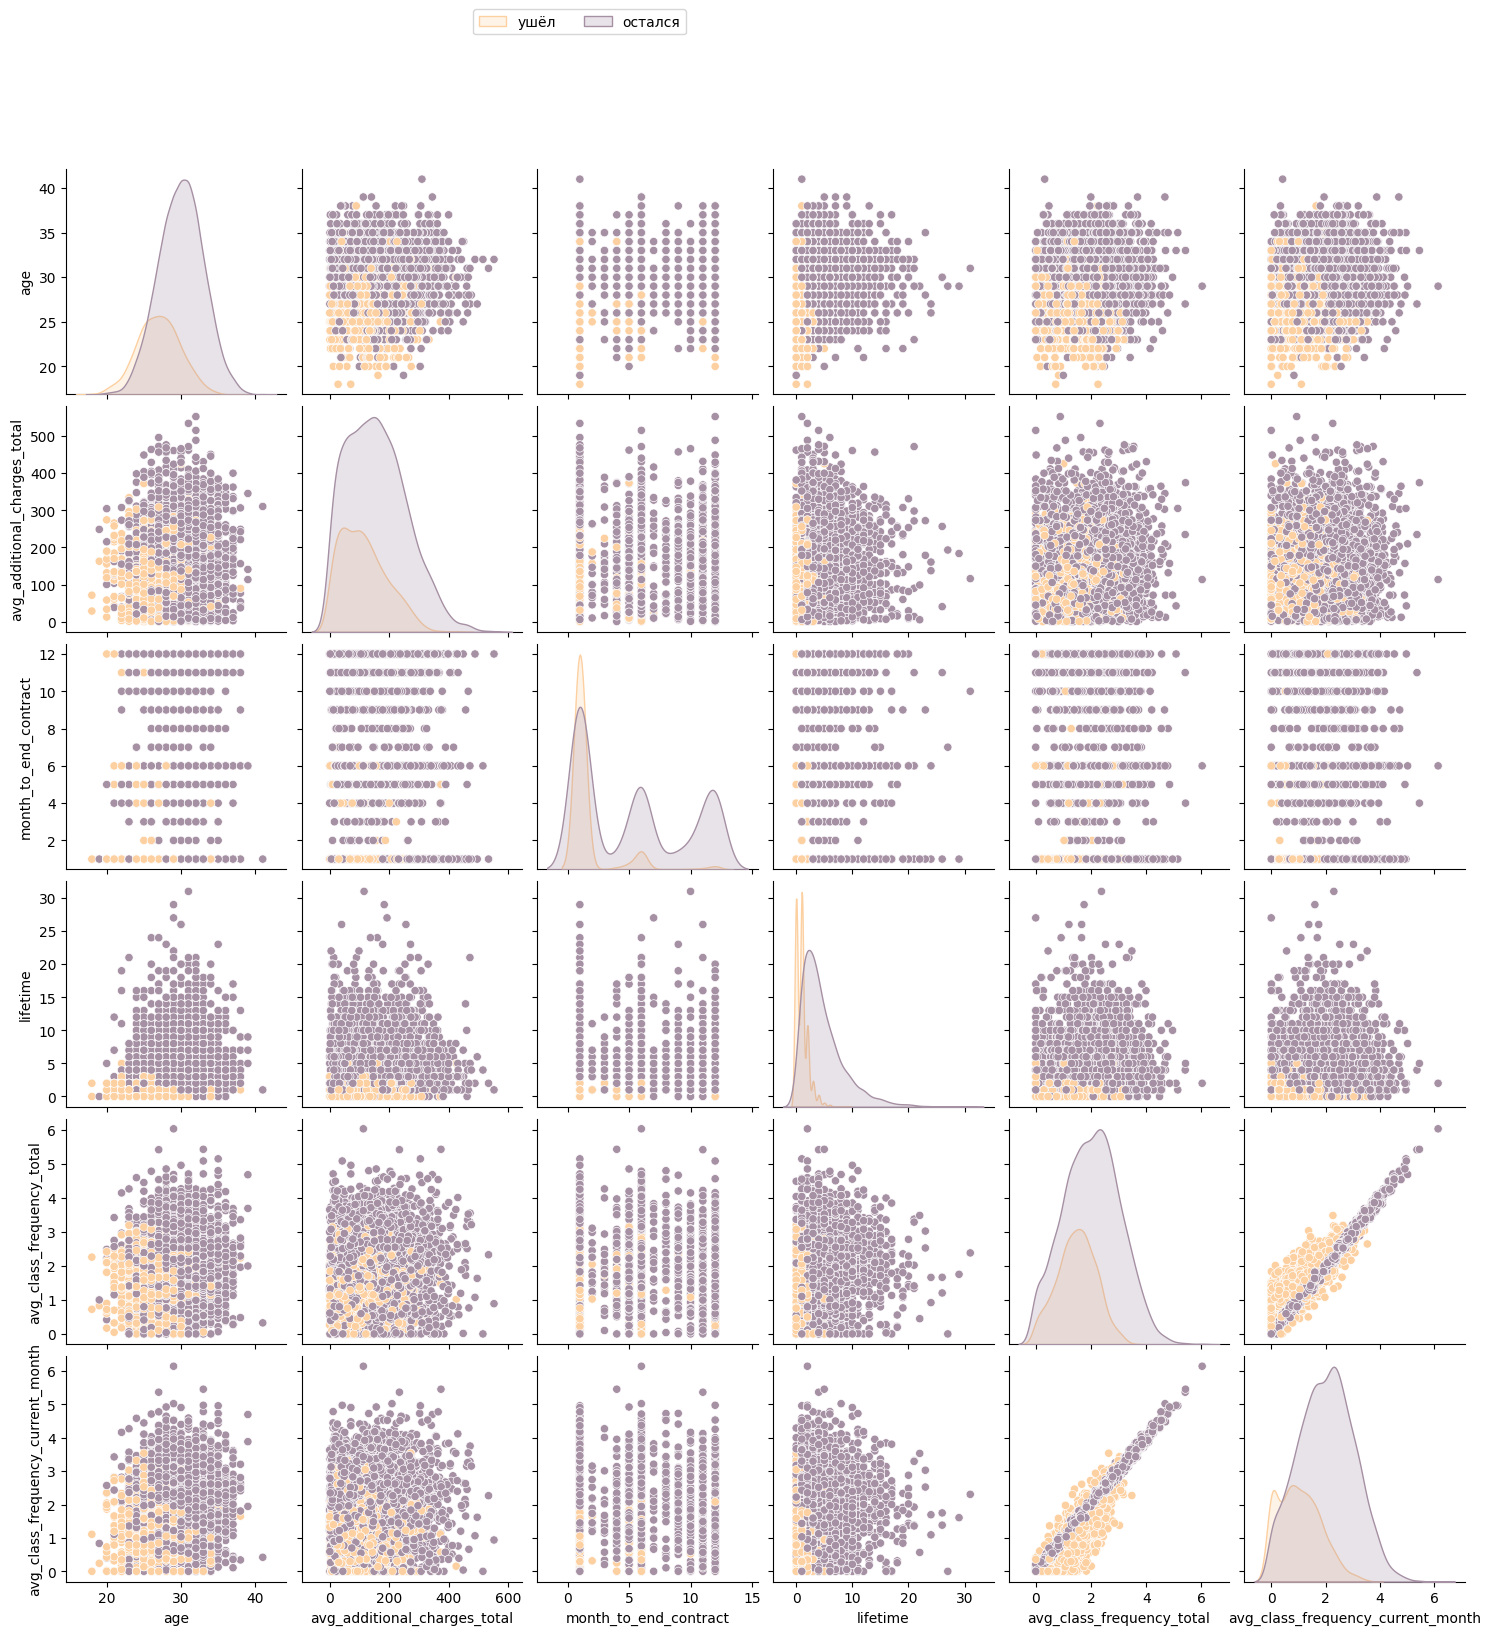

In [15]:
# построим pairplot для признаков из col_hist
ax = sns.pairplot(df[col_hist + ['churn']], 
                  hue='churn',  palette= color)
ax._legend.remove()
plt.legend(['ушёл','остался'], ncol=2, bbox_to_anchor=(-2.5, 7.0))
plt.show()


Клиенты, попавшие в отток имеют хуже показатели по данным признакам:
- среди ушедших больше клиентов до 30 лет
- лайфтаймом меньше 5 месяцев
- их кол-во максимально среди тех, у кого до окончания срока остался 1 месяц
- также они в среднем меньше посещают фитнес-центр
- в последний месяц у них несколько снижается кол-во посещений   

Среди тех, кто дольше является клиентом, чаще посещает занятия меньший процент оттока клиентов.


Учитывая, сдвиг по кол-ву посещений в последний месяц в меньшую сторону среди ушедших клиентов, добавим новый признак

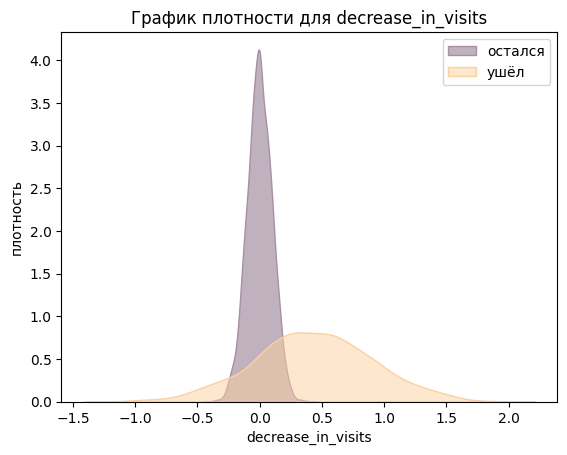

In [16]:
# добавим новый столбец decrease_in_visits
df['decrease_in_visits'] = df['avg_class_frequency_total'] - df['avg_class_frequency_current_month']

# посмотрим на распределение
sns.kdeplot(df[df['churn'] == 0]['decrease_in_visits'], shade=True, 
             color = color[0], alpha=0.7, label= 'остался')
sns.kdeplot(df[df['churn'] == 1]['decrease_in_visits'], shade=True,
             color = color[1], alpha=0.5, label= 'ушёл')
     
plt.legend()
plt.ylabel('плотность')
plt.title('График плотности для decrease_in_visits', fontsize='12');

Разница видна, график подтверждает, что у ушедших в последний месяц снижается среднее кол-во посещений в неделю

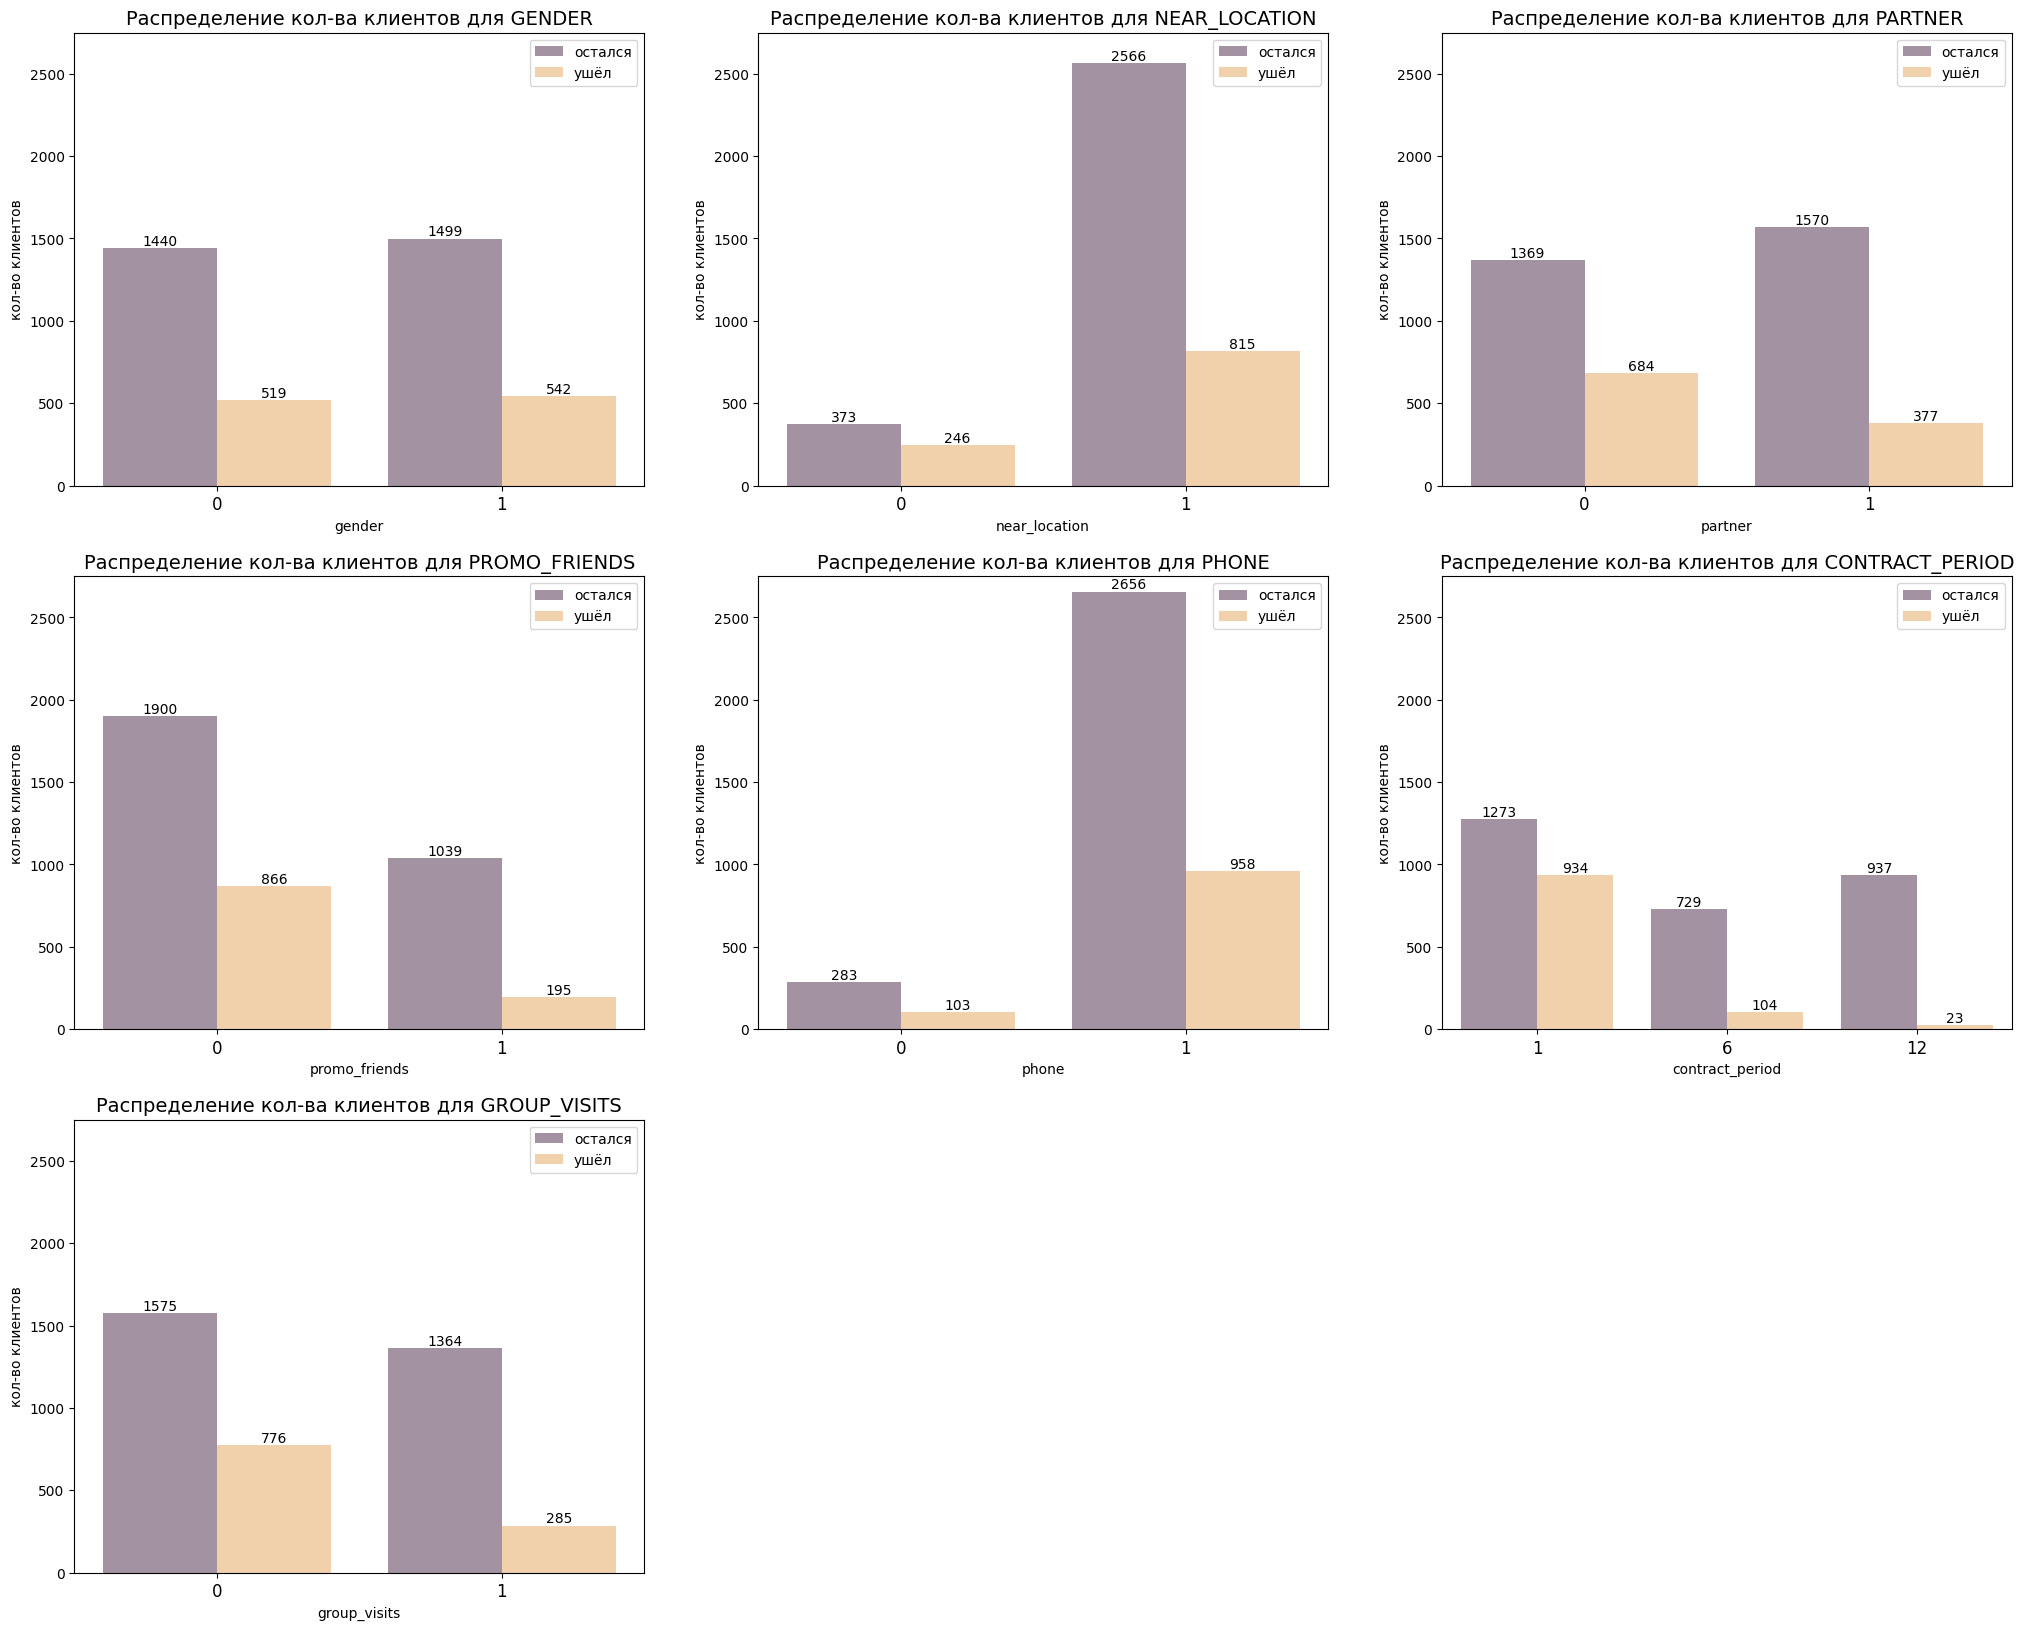

In [17]:
# построим countplot() для столбцов из списка col_plot
fig, ax = plt.subplots(figsize = (25, 20))
for num, col in enumerate(col_plot):
    chart = sns.countplot(x = col, hue = 'churn',  data = df,
             palette= color, 
             ax = plt.subplot(len(col_plot) // 3 + 1, 3, num+1))
    plt.legend(['остался', 'ушёл'])
    signature(chart, "%.0f") 
    plt.xticks(fontsize='12')
    plt.ylabel('кол-во клиентов')
    plt.ylim(0, 2750)
    plt.title('Распределение кол-ва клиентов для '+ col.upper(), fontsize='14')
plt.show()


- 87% от доли ушедших клиентов приходятся клиенты с контрактом на 1 месяц
- доля ушедших клиентов выше среди тех, кто проживает далеко, не является сотрудниками компаний-партнеров, заключившие контракт без промокода, не посещающие групповые занятия 
- доля ушедших среди мужчин и женщин одинаковая
- среди тех, кто указал номер телефона или нет, тоже разницы нет. В дальнейшем желательно, чтобы все клиенты оставляли свой номер

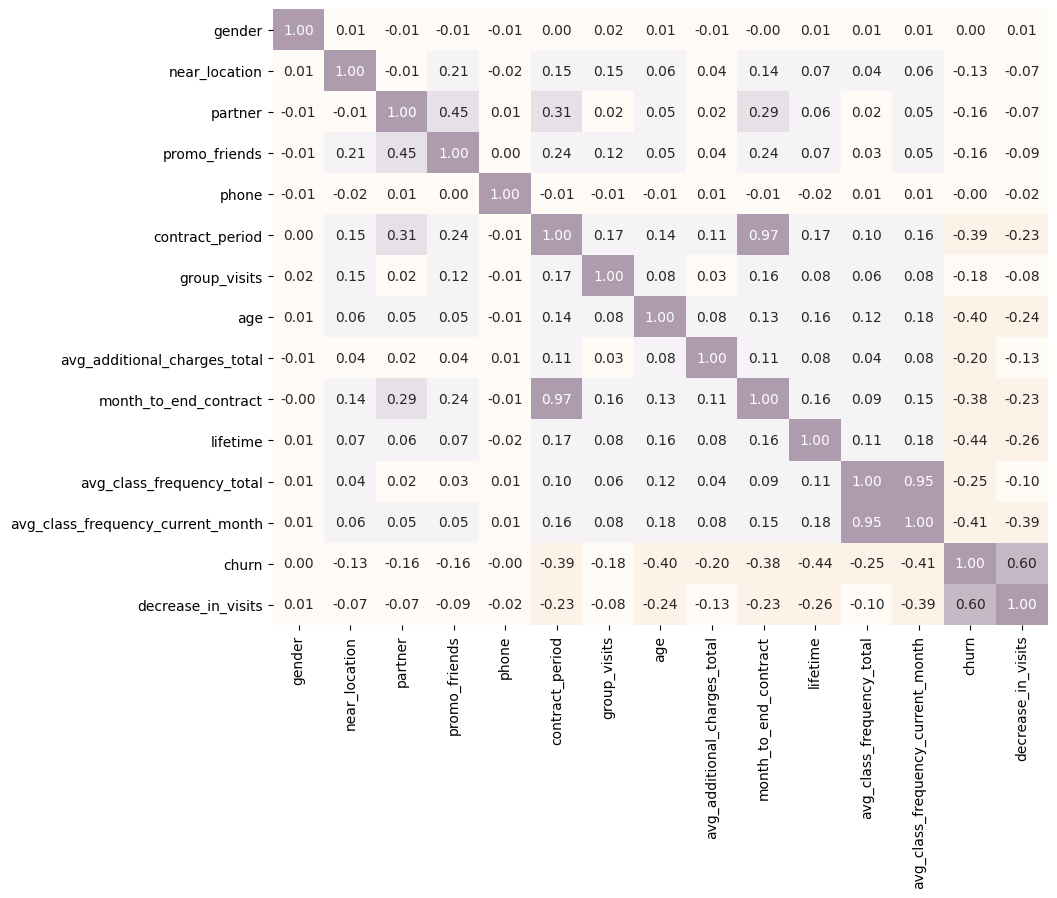

In [18]:
# посмотрим на корреляцию
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), 
            annot=True, 
            fmt='.2f', 
            cmap= ['#fdf2e7','#fefaf6','#f5f3f5', '#e6e1e6', '#c6b9c5', '#ae9bad'],
            cbar=False ) 
plt.show() 

Вывлена сильная корреляция между:
- `avg_class_frequency_current_month` и `avg_class_frequency_total`, ранее сильных различий между этими признаками не наблюдали
- `contract_period` и `month_to_end_contract`, ранее было выявлено, что большинство клиентов имееют контракт на 1 мес и соответственно у большинства клиентов до окончания контракта тоже 1 месяц

Выраженной корреляции между оттоком и другими признаками не выявлено, наибольшая положительная корреляция 0.6 наблюдается только с добавленным признаком 


**Вывод:**

- Доля ушедших клиентов - 26.5%
- Более 23% клиентов - это клиенты, попавшие в отток с контрактом на 1 месяц, т.е. это 87% от доли оттока
- 55% от всех клиентов заключают контракт всего на 1 месяц

`Доля ушедших клиентов выше среди:`
- новых клиентов (лайфтаймом менее 5 месяцев)
- клиентов до 30 лет
- тех, кто заключил договор на 1 месяц и у кого подходит к концу срок действия договора (среди этих признаков выявлена высокая корреляция)
- посещающих фитнес-центр менее 2-х раз в неделю
- проживающих далеко 
- не являющихся сотрудниками компаний-партнеров
- не использующих промокод от друзей



## Модель прогнозирования оттока клиентов
<a id="ml"></a>

### Модель прогнозирования оттока клиентов №1

Для начала спрогнозируем отток на изначальных данных, т.е без учета нового добавленного признака decrease_in_visits и не удаляя  мультиколлинеарные признаки

In [19]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(['churn', 'decrease_in_visits'], axis=1) 
y = df['churn'] 

# разделим модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# должно получится 80/20 процентов
print('Размер обучающей выборки: ', X_train.shape)
print('Размер валидационной выборки: ', X_test.shape)

Размер обучающей выборки:  (3200, 13)
Размер валидационной выборки:  (800, 13)


In [20]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

**Логистическая регрессия**

In [21]:
# задайте алгоритм для нашей модели
lr_model = LogisticRegression(solver='liblinear', random_state=0) 

# обучите модель
lr_model.fit(X_train, y_train)

# воспользуйтесь уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test)
lr_probabilities = lr_model.predict_proba(X_test)[:,1]

# определим функцию, которая будет выводить наши метрики
print_all_metrics(y_test, lr_predictions, lr_probabilities, title='Метрики классификации для логистической регрессии:')
    

Метрики классификации для логистической регрессии:
	Accuracy: 0.93
	Precision: 0.89
	Recall: 0.83
	F1: 0.86
	ROC_AUC: 0.98


**Случайный лес**

In [22]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 

# обучим модель случайного леса
rf_model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test)
rf_probabilities = rf_model.predict_proba(X_test)[:, 1]

# определим функцию, которая будет выводить наши метрики
print_all_metrics(y_test, rf_predictions, rf_probabilities, title='Метрики классификации для случайного леса:')

Метрики классификации для случайного леса:
	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.83
	F1: 0.85
	ROC_AUC: 0.97


Логистическая регрессия показывает лучший результат.  
Попробуем подобрать параметры для Случайного леса, возможно что-то изменится.

**Подбор параметров для Случайного леса**

Далее с помощью GridSearchCV подберем следующие параметры:
- max_features — число признаков, по которым ищется разбиение
- min_samples_leaf — минимальное число объектов в листе
- max_depth — максимальная глубина дерева  

Так как подбор занимает длительное время, я код закоментировала 

In [23]:
'''
# объявляем классификатор RandomForest
clf = RandomForestClassifier(n_estimators=100, random_state = 0, n_jobs=-1)

# создаем словарь параметров
parametrs = {
              'max_features': [2, 4, 6, 8, 10, 12, 13],
              'max_depth': range (2, 11, 1),
              'min_samples_leaf': range (2,8)
            } 
# запускаем обучение
grid = GridSearchCV( clf,  parametrs, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
# выводим лучшие параметры
grid.best_params_
'''

"\n# объявляем классификатор RandomForest\nclf = RandomForestClassifier(n_estimators=100, random_state = 0, n_jobs=-1)\n\n# создаем словарь параметров\nparametrs = {\n              'max_features': [2, 4, 6, 8, 10, 12, 13],\n              'max_depth': range (2, 11, 1),\n              'min_samples_leaf': range (2,8)\n            } \n# запускаем обучение\ngrid = GridSearchCV( clf,  parametrs, cv=5, n_jobs=-1)\ngrid.fit(X_train, y_train)\n# выводим лучшие параметры\ngrid.best_params_\n"

**Лучшие параметры:** {'max_depth': 10, 'max_features': 12, 'min_samples_leaf': 2}

In [24]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса с подобраннымии параметрами 
rfc_model = RandomForestClassifier(n_estimators = 100, max_depth=10, max_features=12, min_samples_leaf=2, n_jobs=-1,
                                   random_state = 0) 
# обучим модель случайного леса
rfc_model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rfc_predictions = rfc_model.predict(X_test)
rfc_probabilities = rfc_model.predict_proba(X_test)[:, 1]

# определим функцию, которая будет выводить наши метрики
print_all_metrics(y_test, rfc_predictions, rfc_probabilities, 
                  title='Метрики классификации для случайного леса с подобранными параметрами:')

Метрики классификации для случайного леса с подобранными параметрами:
	Accuracy: 0.93
	Precision: 0.87
	Recall: 0.86
	F1: 0.86
	ROC_AUC: 0.97


С подобранными параметрами видно, что возрасла  доля правильных ответов (accuracy),  полнота (recall), F1_score. ROC_AUC остался на прежнем уровне. Precision снизился с 0.88 до 0.87

### Модель прогнозирования оттока клиентов №2

Добавим новый признак decrease_in_visits и исключим avg_class_frequency_current_month и month_to_end_contract

In [25]:
# разделим наши данные на признаки (матрица X1) и целевую переменную (y1)
X1 = df.drop(['churn', 'avg_class_frequency_current_month', 'month_to_end_contract'], axis=1) 
y1 = df['churn'] 

# разделим модель на обучающую и валидационную выборки
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=0, stratify=y)

print('Размер обучающей выборки: ', X1_train.shape)
print('Размер валидационной выборки: ', X1_test.shape)

Размер обучающей выборки:  (3200, 12)
Размер валидационной выборки:  (800, 12)


**Логистическая регрессия**

In [26]:
# задайте алгоритм для нашей модели
lr1_model = LogisticRegression(solver='liblinear', random_state=0) 

# обучите модель
lr1_model.fit(X1_train, y1_train)

# воспользуйтесь уже обученной моделью, чтобы сделать прогнозы
lr1_predictions = lr1_model.predict(X1_test)
lr1_probabilities = lr1_model.predict_proba(X1_test)[:,1]

# определим функцию, которая будет выводить наши метрики
print_all_metrics(y1_test, lr1_predictions, lr1_probabilities, 
                  title='Метрики классификации для логистической регрессии с новым признаком:')
    

Метрики классификации для логистической регрессии с новым признаком:
	Accuracy: 0.93
	Precision: 0.89
	Recall: 0.83
	F1: 0.86
	ROC_AUC: 0.98


Немного снизились метрики recall и F1

**Случайный лес**

In [27]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf1_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 

# обучим модель случайного леса
rf1_model.fit(X1_train, y1_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf1_predictions = rf1_model.predict(X1_test)
rf1_probabilities = rf1_model.predict_proba(X1_test)[:, 1]

# определим функцию, которая будет выводить наши метрики
print_all_metrics(y1_test, rf1_predictions, rf1_probabilities, 
                  title='Метрики классификации для случайного леса с новым признаком:')

Метрики классификации для случайного леса с новым признаком:
	Accuracy: 0.96
	Precision: 0.97
	Recall: 0.87
	F1: 0.92
	ROC_AUC: 0.99


А для случайного леса при добавлении нового признака, все метрики возросли 

**Подбор параметров для Случайного леса**

Так как подбор занимает длительное время, код закоментировала 

In [28]:
'''
# объявляем классификатор RandomForest
clf1 = RandomForestClassifier(n_estimators=100, random_state = 0, n_jobs=-1)

# создаем словарь параметров
parametrs = {
              'max_features': [2, 4, 6, 8, 10, 12],
              'max_depth': range (2, 11, 1),
              'min_samples_leaf': range (2,8)
            } 
# запускаем обучение
grid = GridSearchCV(clf1,  parametrs, cv=5, n_jobs=-1)
grid.fit(X1_train, y1_train)
# выводим лучшие параметры
grid.best_params_
'''


"\n# объявляем классификатор RandomForest\nclf1 = RandomForestClassifier(n_estimators=100, random_state = 0, n_jobs=-1)\n\n# создаем словарь параметров\nparametrs = {\n              'max_features': [2, 4, 6, 8, 10, 12],\n              'max_depth': range (2, 11, 1),\n              'min_samples_leaf': range (2,8)\n            } \n# запускаем обучение\ngrid = GridSearchCV(clf1,  parametrs, cv=5, n_jobs=-1)\ngrid.fit(X1_train, y1_train)\n# выводим лучшие параметры\ngrid.best_params_\n"

 **Лучшие параметры:** {'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 2}

In [29]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса с подобраннымии параметрами 
rfc1_model = RandomForestClassifier(n_estimators = 100, max_depth=10, max_features=4, min_samples_leaf=2, n_jobs=-1,
                                   random_state = 0) 
# обучим модель случайного леса
rfc1_model.fit(X1_train, y1_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rfc1_predictions = rfc1_model.predict(X1_test)
rfc1_probabilities = rfc1_model.predict_proba(X1_test)[:, 1]

# определим функцию, которая будет выводить наши метрики
print_all_metrics(y1_test, rfc1_predictions, rfc1_probabilities, 
                  title='Метрики классификации для случайного леса с подобранными параметрами:')

Метрики классификации для случайного леса с подобранными параметрами:
	Accuracy: 0.95
	Precision: 0.95
	Recall: 0.86
	F1: 0.91
	ROC_AUC: 0.99


In [30]:
# посмотрим на важность признаков для изначальных признаков
importances = pd.DataFrame(data={
    'признак': X.columns,
    'важность': rfc_model.feature_importances_ 
})
importances.round(2).sort_values(by= 'важность', ascending=False)

признак  важность
10                           lifetime      0.38
12  avg_class_frequency_current_month      0.17
11          avg_class_frequency_total      0.15
7                                 age      0.09
9               month_to_end_contract      0.09
8        avg_additional_charges_total      0.06
5                     contract_period      0.04
0                              gender      0.01
6                        group_visits      0.01
1                       near_location      0.00
2                             partner      0.00
3                       promo_friends      0.00
4                               phone      0.00

Первый по важности стоит лайфтайм

In [31]:
# посмотрим на важность признаков с добавленным новым признаком
importances = pd.DataFrame(data={
    'признак': X1.columns,
    'важность': rfc1_model.feature_importances_ 
})
importances.round(2).sort_values(by= 'важность', ascending=False)


признак  важность
11            decrease_in_visits      0.53
9                       lifetime      0.20
5                contract_period      0.08
7                            age      0.08
10     avg_class_frequency_total      0.05
8   avg_additional_charges_total      0.03
6                   group_visits      0.01
0                         gender      0.00
1                  near_location      0.00
2                        partner      0.00
3                  promo_friends      0.00
4                          phone      0.00

Здесь уже первым по важности стоит разница  в сред. значении посещении за неделю в последний месяц и за все время, лайфтайм на 2 месте

**Вывод:**
Все модели и с добавлением нового признака и без него показали хорошие результаты, но лучше всего показал случайный лес с новым признаком.


## Кластеризация клиентов
<a id="km"></a>

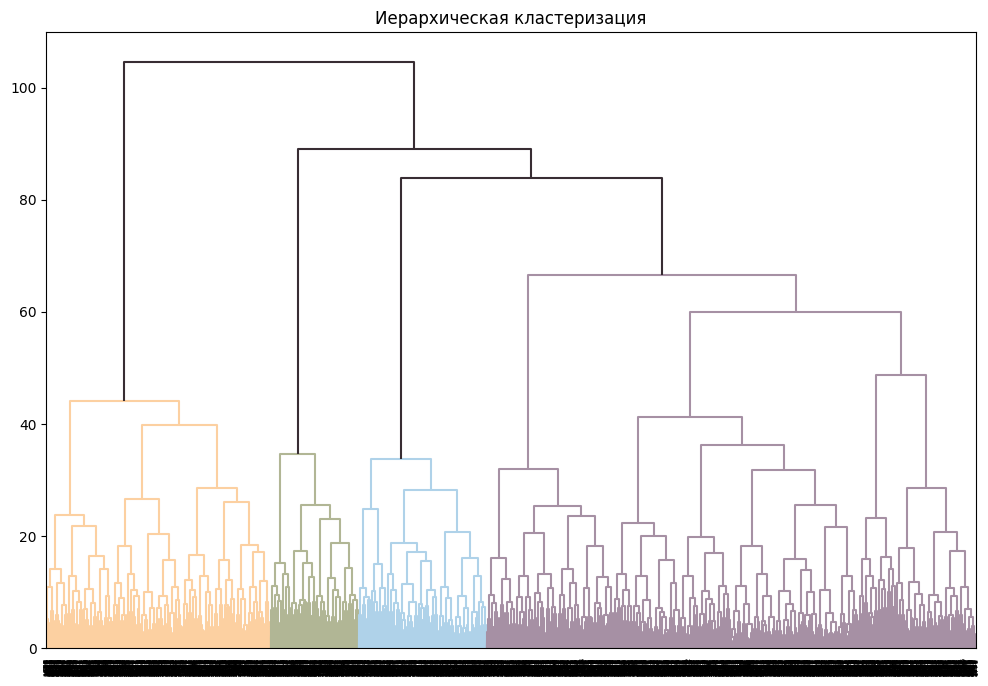

In [32]:
# обязательная стандартизация данных перед работой с алгоритмами

sc = StandardScaler()
X_sc = sc.fit_transform(X)
linked = linkage(X_sc, method = 'ward')

# поработаем с цветом и построим дендрограмму
hierarchy.set_link_color_palette(['#FCD0A1', '#B1B695', '#AFD2E9', '#A690A4', '#EAE5EA'])

plt.figure(figsize=(12, 8))  
dendrogram(linked, orientation='top',  above_threshold_color= '#382D33')

plt.title('Иерархическая кластеризация')
hierarchy.set_link_color_palette(None)
plt.show()

По данным дендрограммы оптимальное разделение на 4 кластера, но по условию нам нужно разделить на 5 

Silhouette_score: 0.14


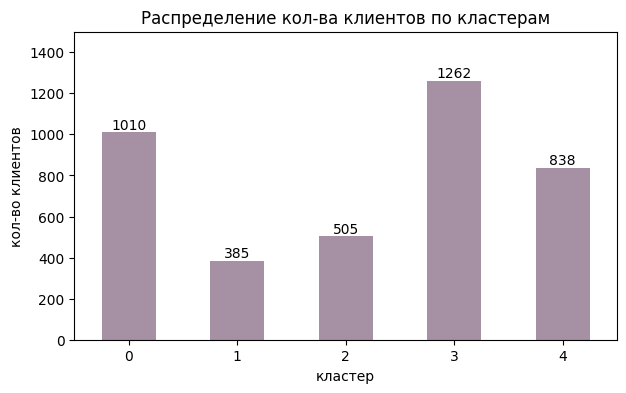

In [33]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)

# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
df['cluster_km'] = labels

# посчитаем метрику силуэта для нашей кластеризации
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

# посмотрим на количество клиентов в каждом кластере
chart = df['cluster_km'].value_counts().sort_index().plot(kind='bar', 
                                    rot=0, 
                                    figsize=(7,4), 
                                    color = color[0])
plt.ylim(0, 1500)
plt.ylabel('кол-во клиентов')
plt.xlabel('кластер')
plt.title("Распределение кол-ва клиентов по кластерам")
signature(chart, "%.0f")
plt.show()

Метрика силуэта невысокая и равна 0,14  
Наиболее многочисленным вышел 3 кластер, меньше всего клиентов в 1 кластере

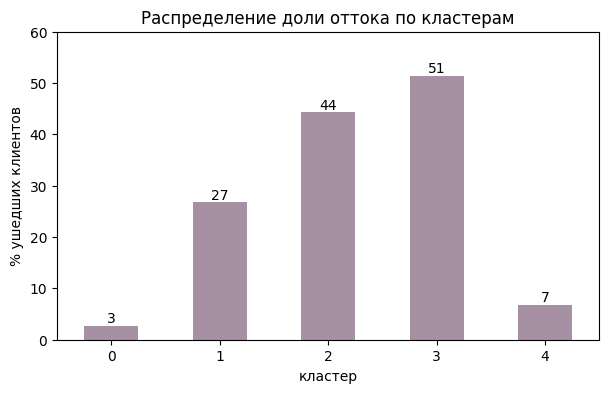

In [34]:
# посмотрим на долю оттока по кластерам
chart= df.groupby('cluster_km')['churn'].agg('mean').apply(lambda x: round(x * 100, 2)).plot(kind='bar', 
                                                                                      rot=0, 
                                                                                      figsize=(7,4), 
                                                                                      color = color[0])
plt.ylabel('% ушедших клиентов')
plt.xlabel('кластер')
plt.ylim(0, 60)
plt.title("Распределение доли оттока по кластерам")
signature(chart, "%.0f")
plt.show()

Наибольшая доля оттока (51%) наблюдается в самом многочисленном 3 кластере, меньше всего в 0 кластере (3%).

In [35]:
# найдем средние значения прищнаков для каждого кластера
df.groupby('cluster_km').agg('mean').round(2).T

cluster_km                              0       1       2       3       4
gender                               0.50    0.52    0.50    0.49    0.56
near_location                        0.96    0.86    0.00    1.00    0.98
partner                              0.78    0.47    0.46    0.35    0.36
promo_friends                        0.57    0.31    0.08    0.24    0.23
phone                                1.00    0.00    1.00    1.00    1.00
contract_period                     10.89    4.79    2.35    1.95    2.67
group_visits                         0.54    0.43    0.22    0.34    0.47
age                                 29.98   29.30   28.48   28.17   30.13
avg_additional_charges_total       160.76  143.96  135.46  131.62  161.66
month_to_end_contract                9.95    4.48    2.20    1.86    2.46
lifetime                             4.74    3.92    2.81    2.44    4.90
avg_class_frequency_total            1.98    1.85    1.66    1.25    2.85
avg_class_frequency_current_month    1.97    1.72    1.48    1.01    2.85
churn                                0.03    0.27    0.44    0.51    0.07
decrease_in_visits                   0.01    0.13    0.18    0.23    0.00

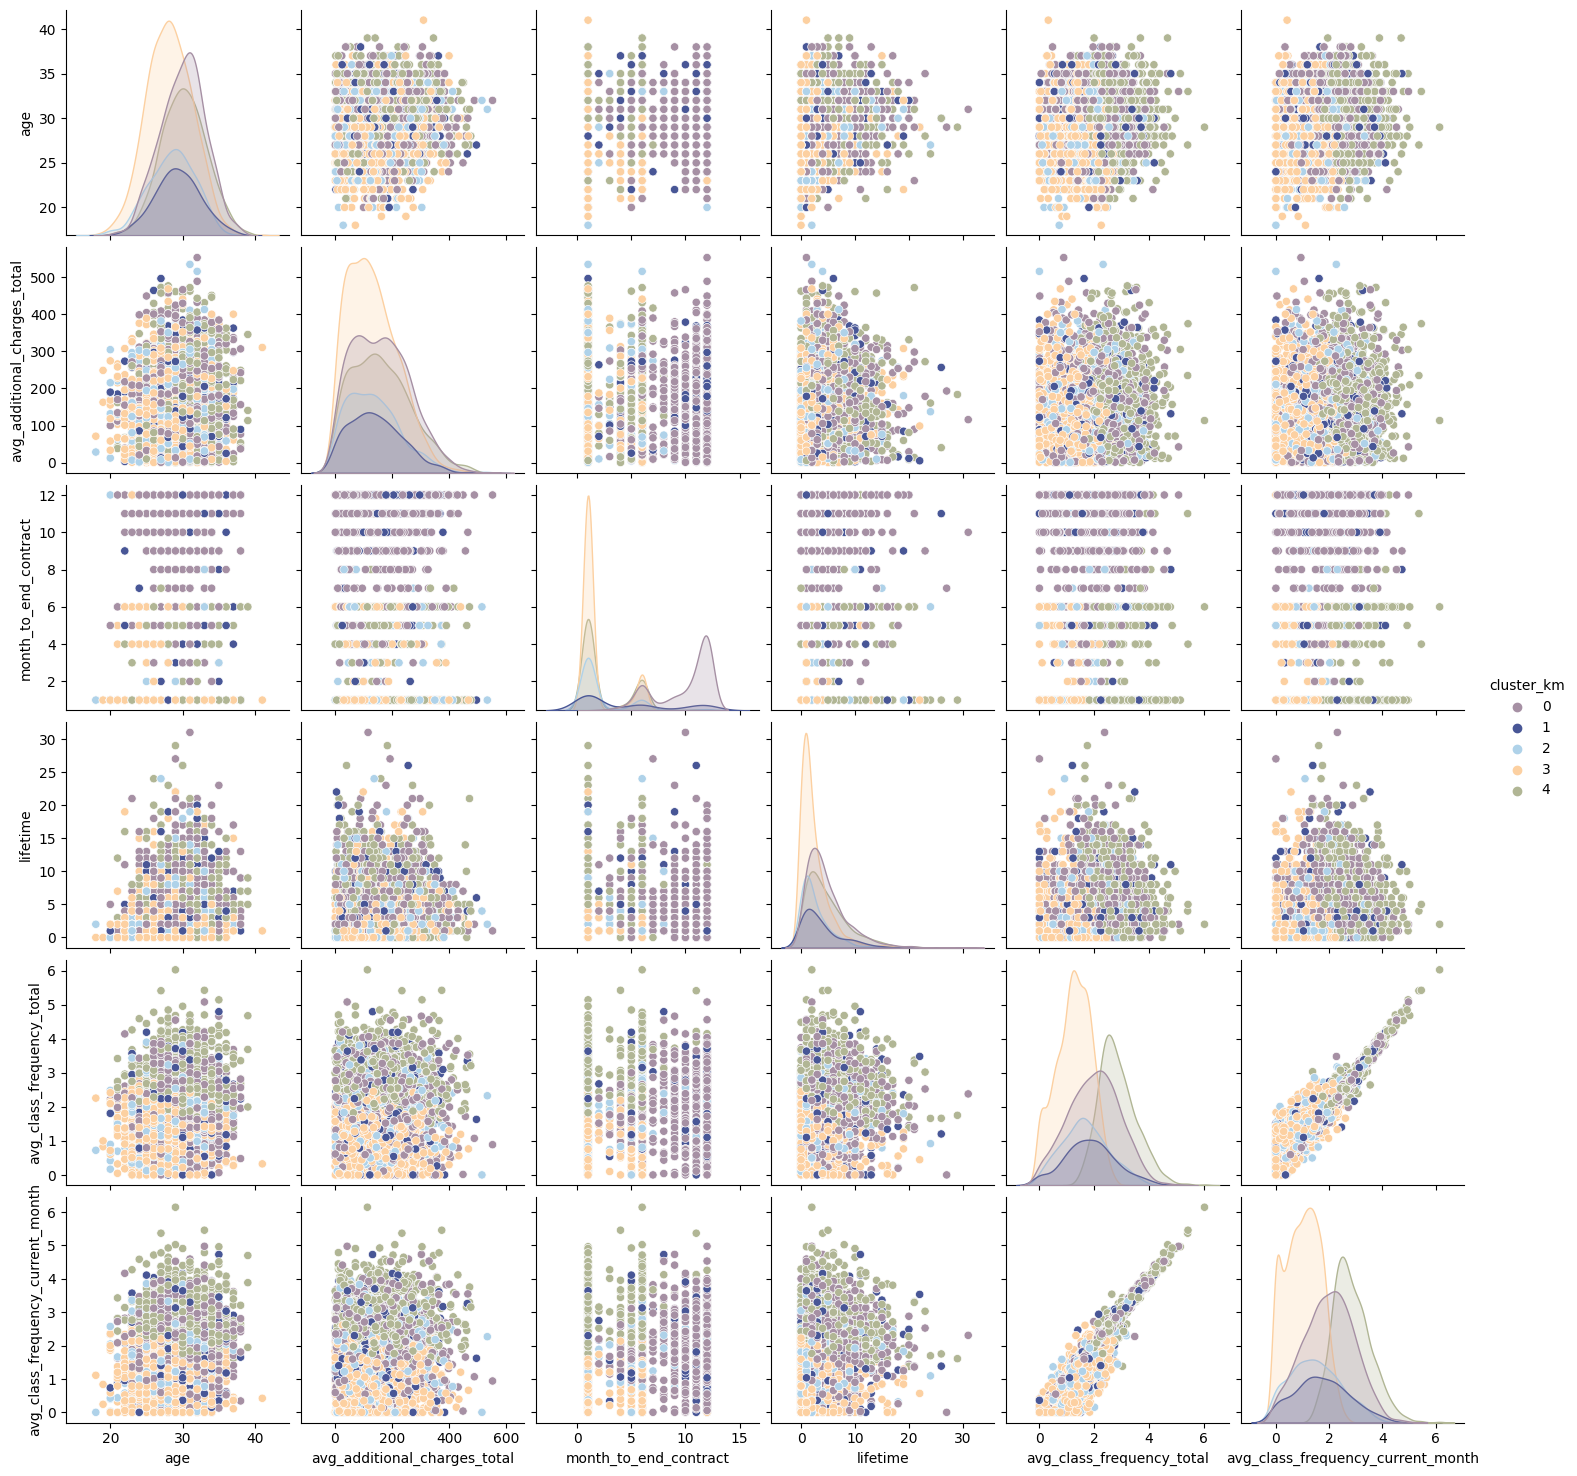

In [36]:
# построим pairplot для признаков из col_hist
palette = ['#A690A4','#485696', '#AFD2E9', '#FCD0A1', '#B1B695']
ax = sns.pairplot(df[col_hist +['cluster_km']], 
                  hue='cluster_km',  palette= palette)

plt.show()


Четко отделяемых групп на графике не видно

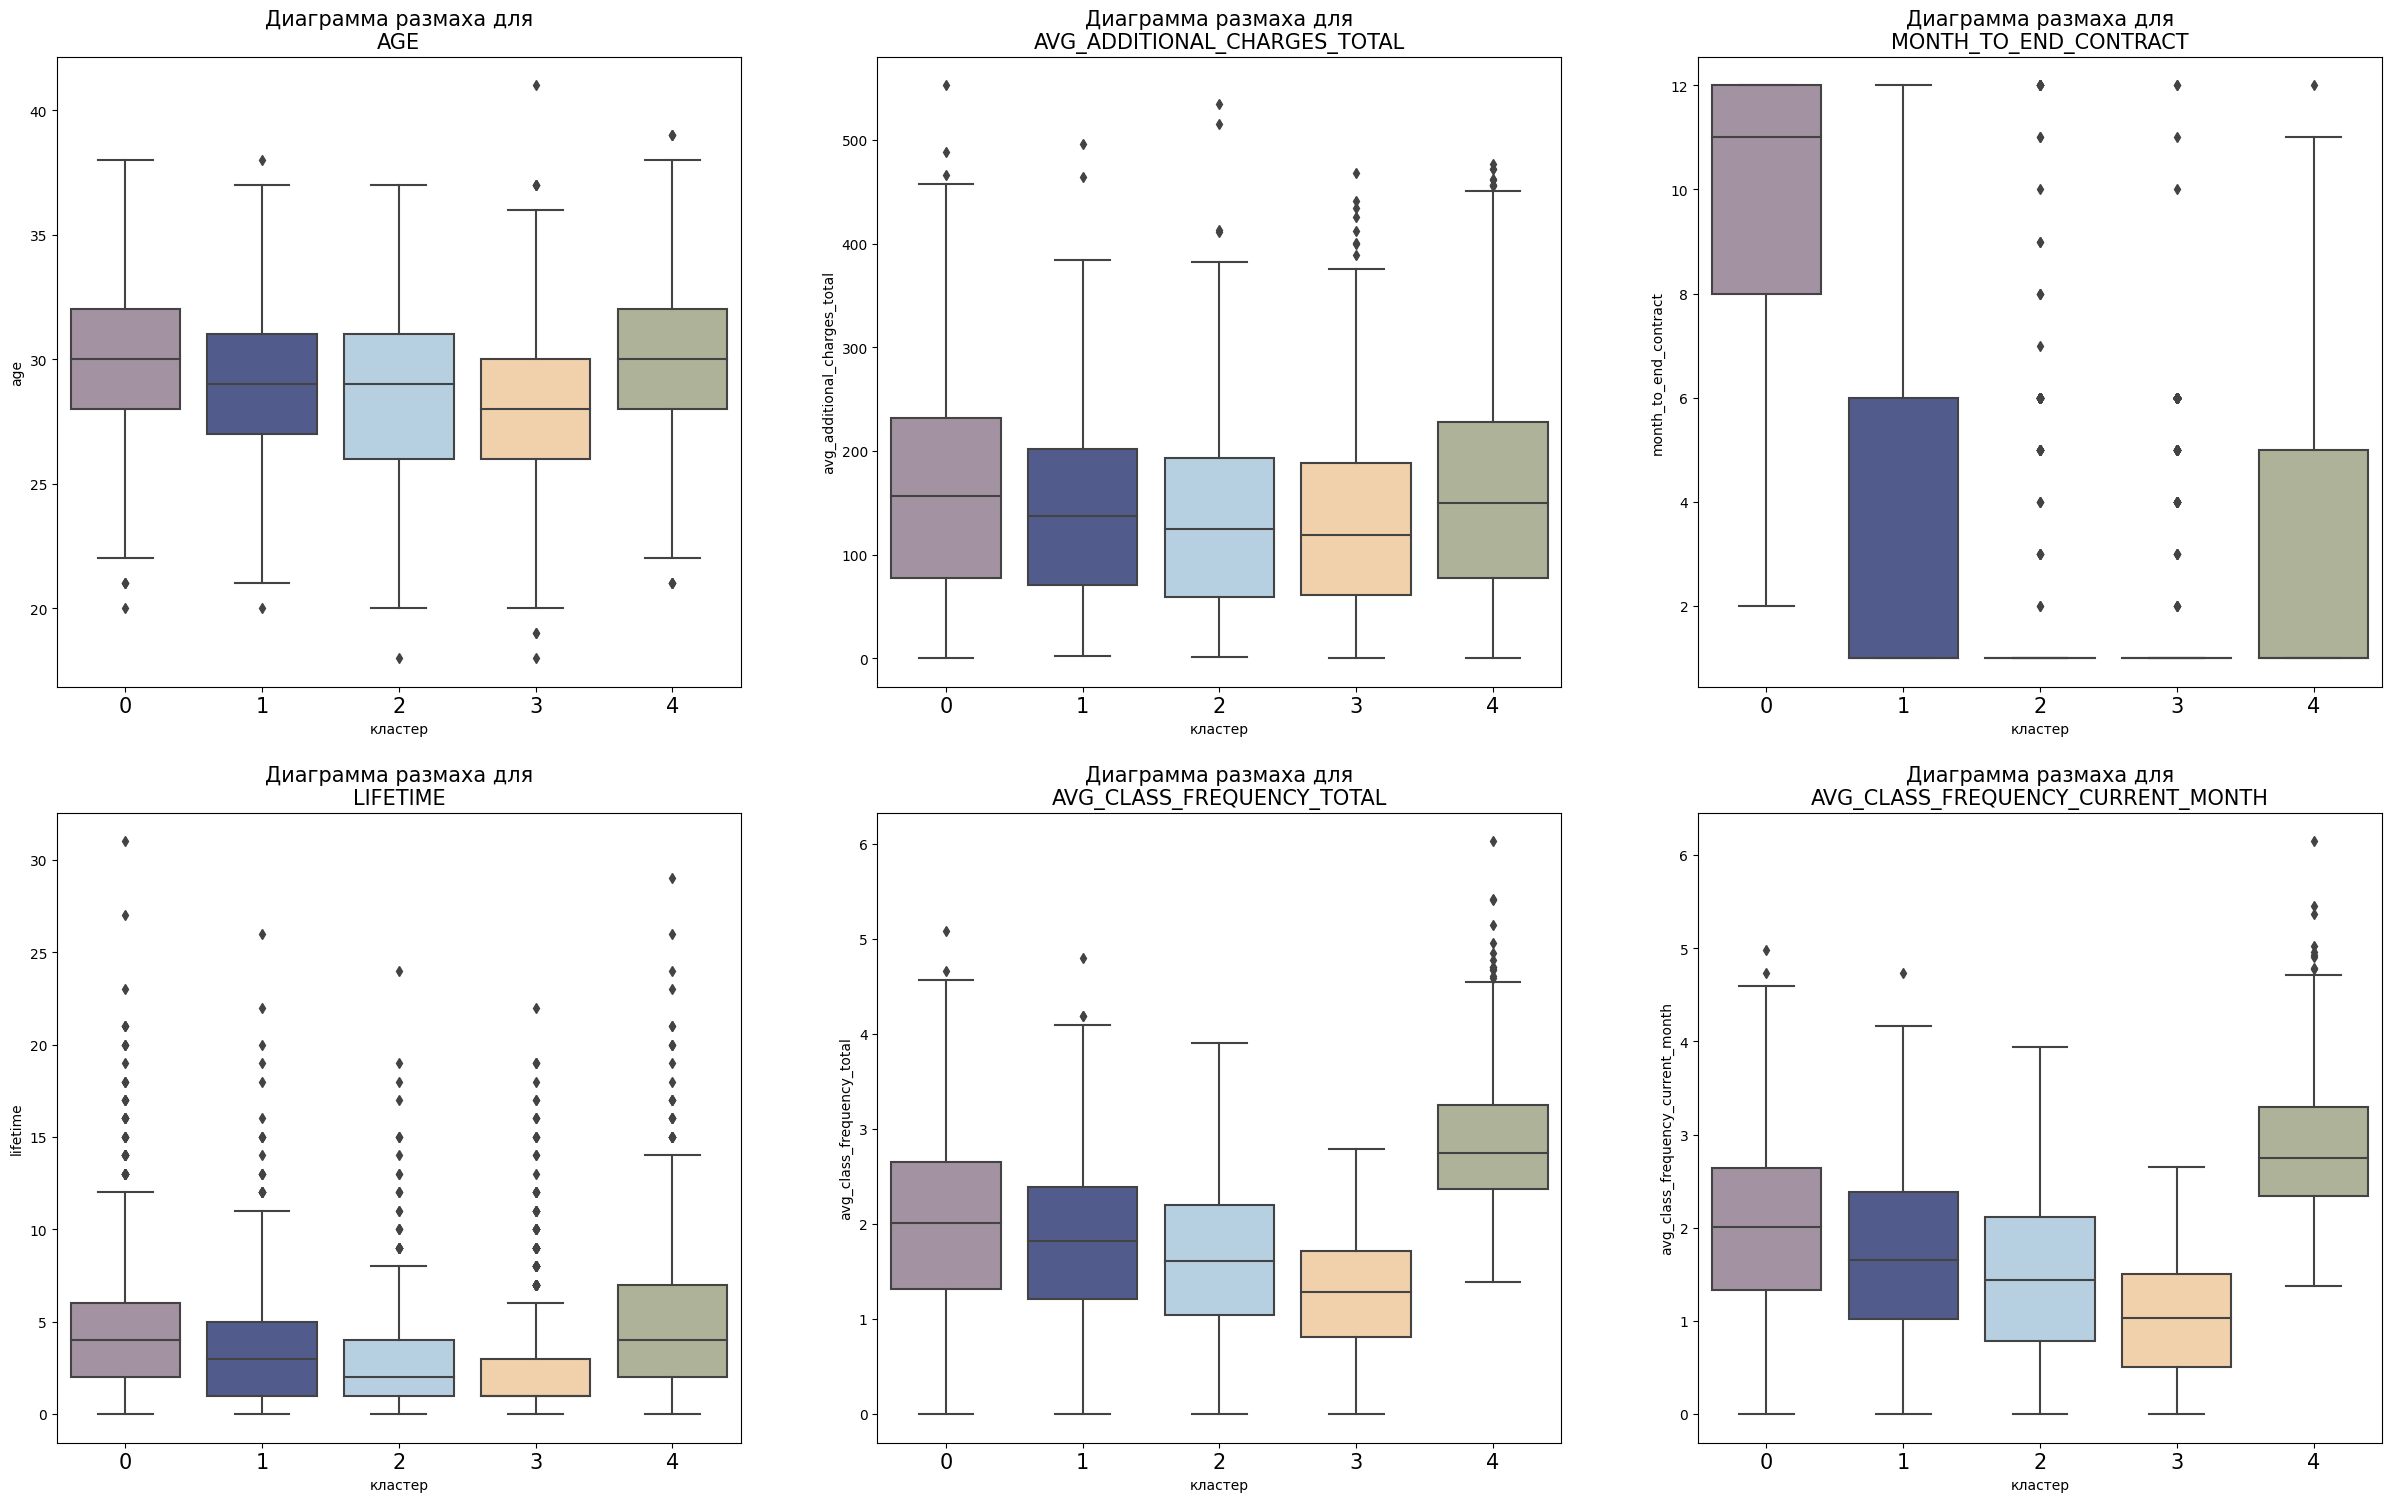

In [37]:
# построим боксплоты для признаков из col_hist
fig, ax = plt.subplots(figsize = (30, 18))
for num, col in enumerate(col_hist):
    sns.boxplot(x = 'cluster_km', y = col,  data = df,
             palette=palette, 
             ax = plt.subplot(2, 3, num+1))
    plt.ylabel(col)
    plt.xlabel('кластер')
    plt.xticks(fontsize='15')
    plt.title('Диаграмма размаха для\n'+ col.upper(), fontsize='15')
plt.show()

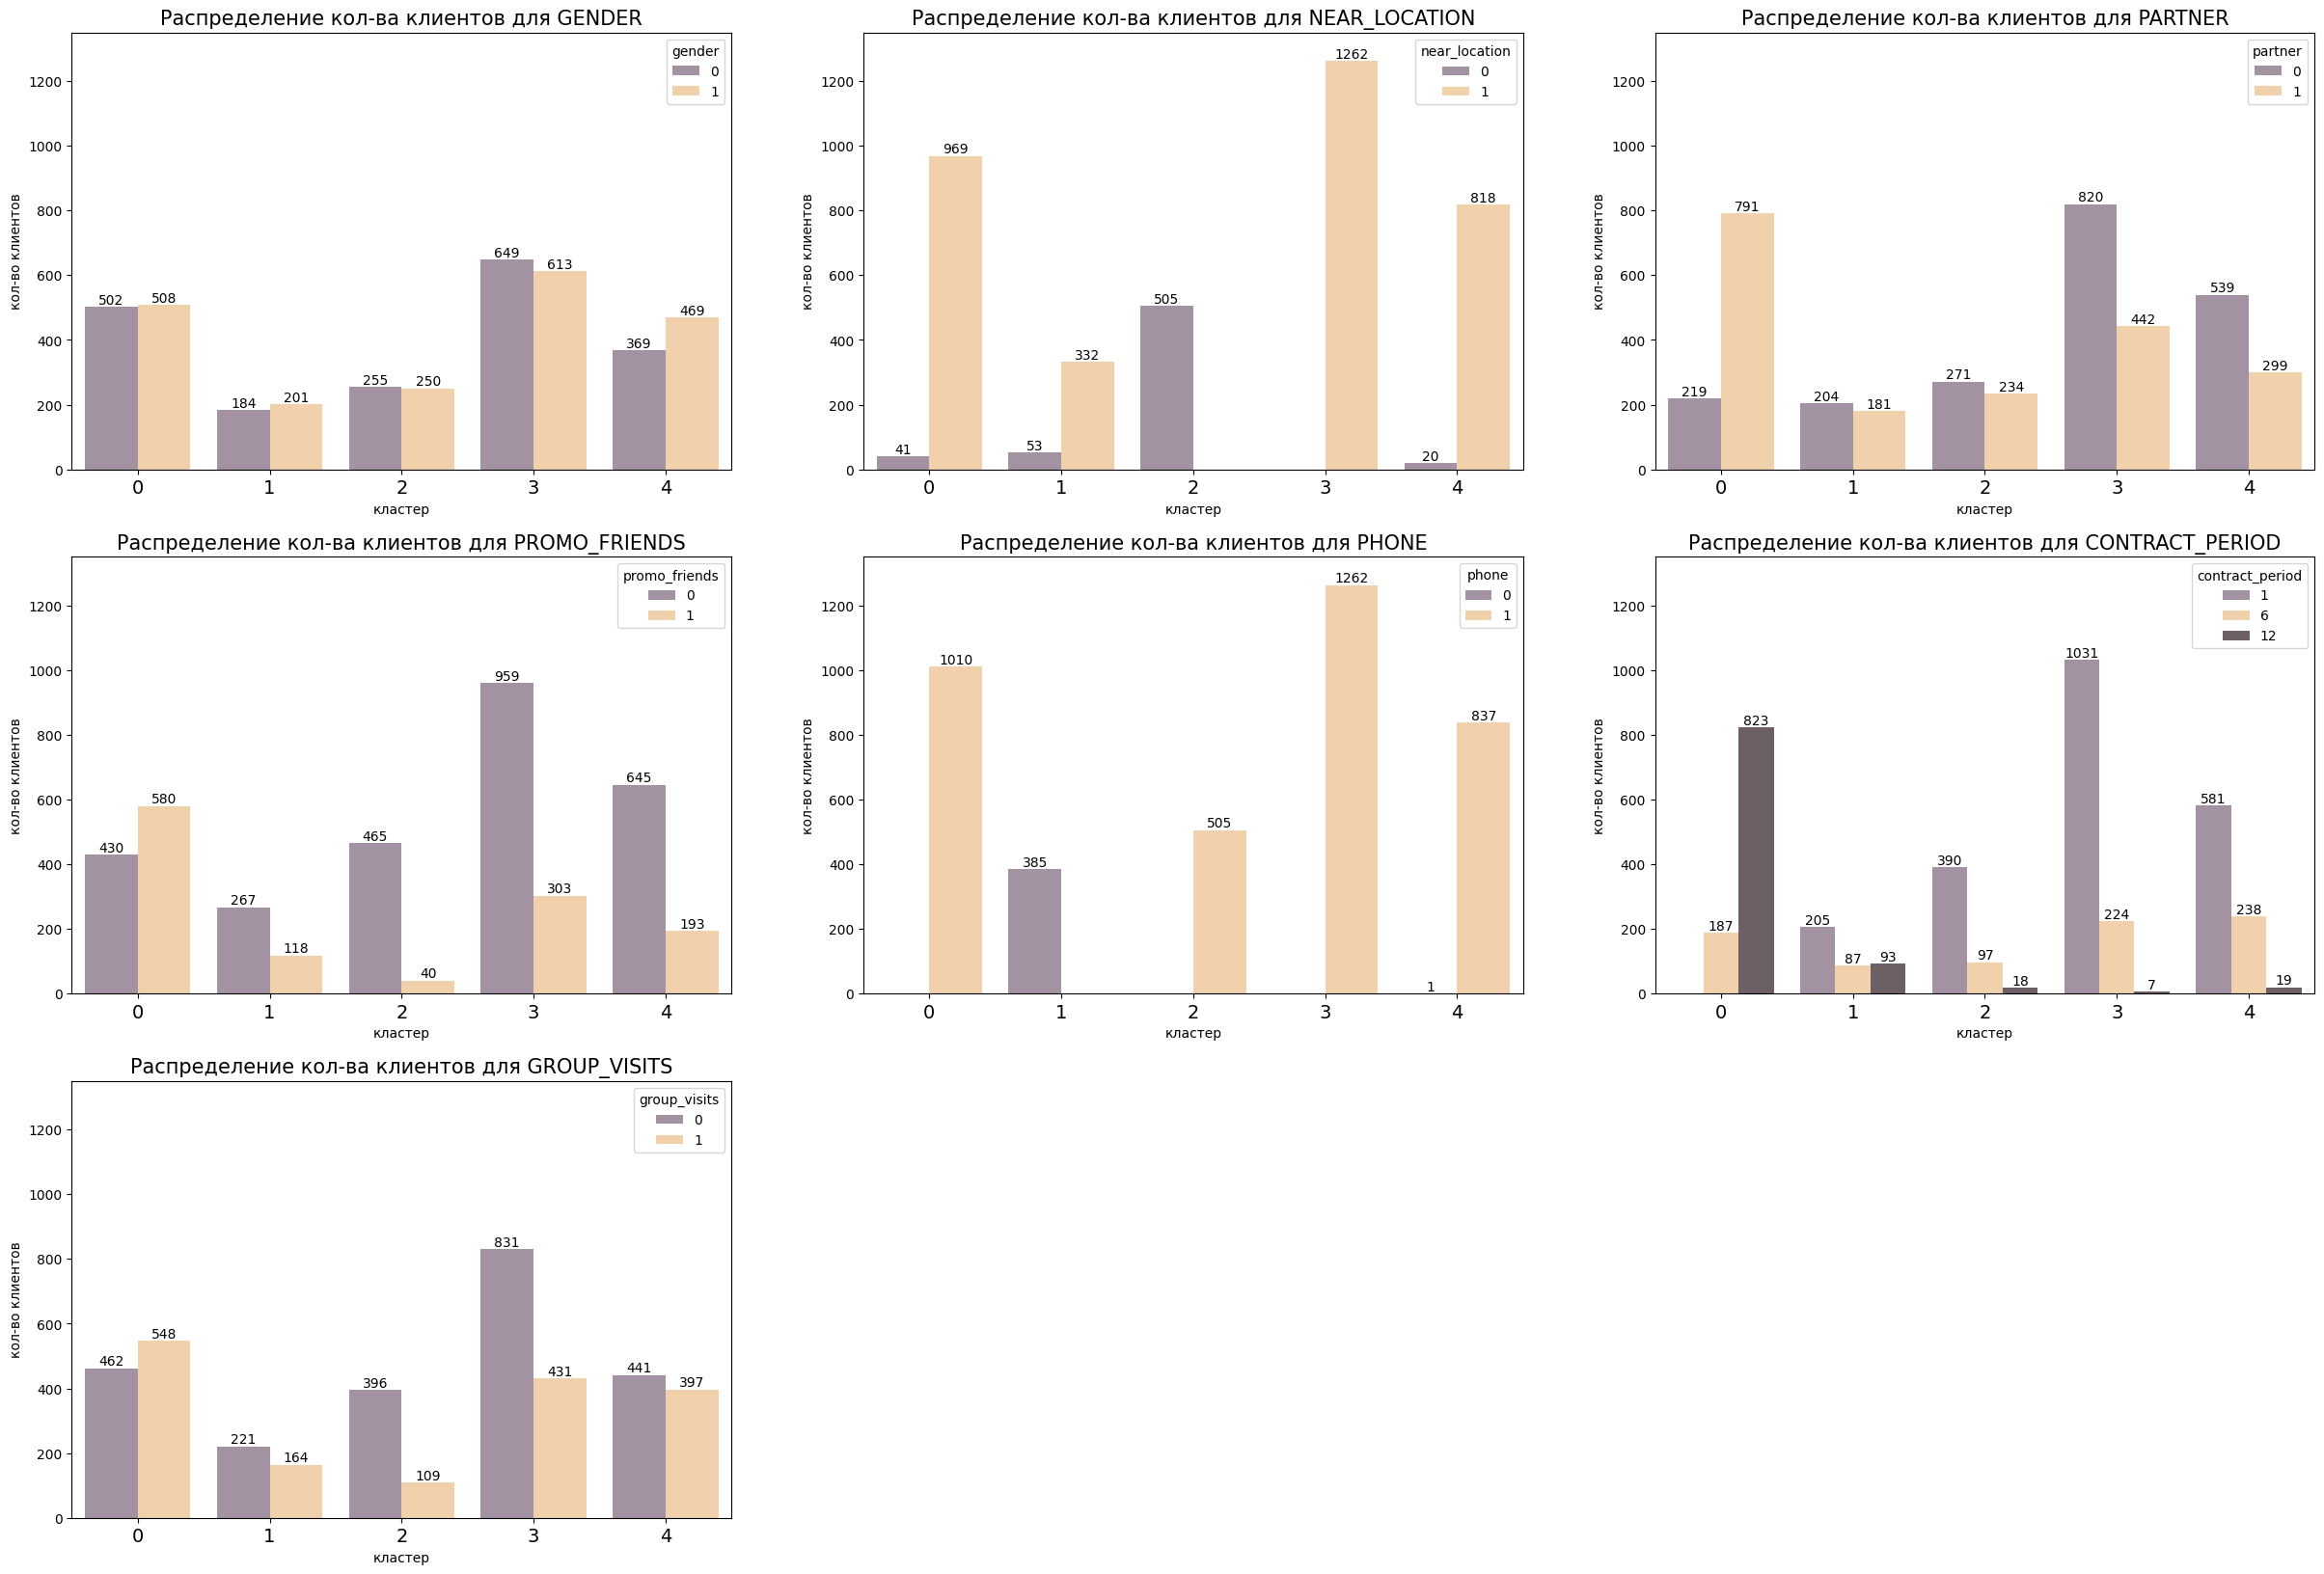

In [38]:
# построим countplot() для столбцов из списка col_plot для каждого кластера
fig, ax = plt.subplots(figsize = (30, 20))
for num, col in enumerate(col_plot):
    chart = sns.countplot(x = 'cluster_km', hue = col,  data = df,
             palette= ['#A690A4', '#FCD0A1', '#6E5D66'],
             ax = plt.subplot(3, 3, num+1))
    signature(chart, "%.0f") 
    plt.xticks(fontsize='14')
    plt.ylabel('кол-во клиентов')
    plt.xlabel('кластер')
    plt.ylim(0, 1350)
    plt.title('Распределение кол-ва клиентов для '+ col.upper(), fontsize='15')
plt.show()

**`Характеристики кластеров`**

**0 кластер** - самые надежные с долгосрочными контрактами
- доля отттока - **3%**
- в него вошли около 25% от всех клиентов
- заключающие контракты в основном на 1 год (81.5%), реже на 6 месяцев, в этом кластере нет клиентов с контрактом на 1 месяц
- до окончания контракта в среднем около 10 месяц, т.е. не так давно его заключили 
- с лайфтаймом около 5 месяцев
- средним возрастом около 30 лет
- проживающие рядом с фитнес-центром
- посещающих занятия в среднем 2 раза в неделю, но среди них есть и те, кто ходит 1 и менее раз
- 54% посещают групповые занятия
- больше половины (57%) воспользовались промокодами от друзей
- 78% являются сотрудниками компаний-партнеров
- высокий средний чек на дополнительные услуги - 161

**4 кластер** - надежные и мотивированные с высокой долей краткосрочных контрактов
- доля оттока - **7%**
- в него вошли около 21% от всех клиентов
- 70% клиентов этого кластера заключают контракты на 1 месяц и около 2% всего на год
- до окончания контракта в среднем около 2,5 месяца
- с самым высоким лайфтаймом, в среднем 5 месяцев. Видимо многие повторно заключают контракты на 1 мес
- клиенты постарше, со средним возрастом около 30 лет
- проживающие рядом с фитнес-центром
- посещающих занятия в среднем почти 3 раза в неделю, самые мотивированные клиенты, это единственный кластер, где минимальное значение посещений не равно 0 и составляет 1,5 
- 47% посещают групповые занятия
- 23% воспользовались промокодами от друзей
- 36% являются сотрудниками компаний-партнеров
- высокий среднем чек на дополнительные услуги - 161


**1 кластер** - проживающие далеко, со схожими средними показателями по всем клиентам
- доля оттока - **27%**
- в него вошли около  12% от всех клиентов
- все клиенты из этого кластера проживают далеко
- 53% клиентов этого кластера заключают контракты на 1 месяц и примерно в равных кол-вах на 6 и 12 мес 
- до окончания контракта в среднем около 4,5 месяца
- с  лайфтаймом, в среднем около 4 месяцев. Это ниже, чем у 0 и 4 кластера
- клиенты со средним возрастом около 29 лет
- посещающих занятия в среднем почти 1.85 раза в неделю 
- 43% посещают групповые занятия
- 31% воспользовались промокодами от друзей
- 47% являются сотрудниками компаний-партнеров
- среднем чек на дополнительные услуги ниже - 143

**2 кластер** - ненадежные, без номера телефона
- доля оттока - **44%**
- самый малочисленный кластер, менее 10%
- все клиенты не указали свой номер телефона
- 77% клиентов этого кластера заключают контракты на 1 месяц, около 3,5% на 1 год
- до окончания контракта у большинства клиентов 1 мес, в среднем около 2,2 месяца
- с  лайфтаймом, в среднем около 2.8 месяцев. Это ниже, чем у предыдущих кластеров
- клиенты со средним возрастом около 28.5 лет, здесь уже есть клиенты моложе 20 лет
- большая часть клиентов, проживающие рядом с фитнес-центром
- посещающих занятия от 0 до 4 раз, в среднем почти 1.66 раза в неделю 
- 22% посещают групповые занятия
- 8% воспользовались промокодами от друзей, самый низкий показатель по всем кластерам
- 46% являются сотрудниками компаний-партнеров
- среднем чек на дополнительные услуги ниже - 135

**3 кластер** - особо ненадежные
- доля оттока - **51%**
- самый многочисленный кластер, более 31%
- 82% клиентов этого кластера заключают контракты на 1 месяц, и всего около 0,5% на 1 год
- до окончания контракта почти у всех клиентов 1 мес, в среднем около 1.95 месяца
- с самым низким лайфтаймом, в среднем около 2.4 месяцев. 
- клиенты со средним возрастом около 28.2 лет, здесь уже есть клиенты моложе 20 лет
- большая часть клиентов, проживающие рядом с фитнес-центром
- посещающих занятия от 0 до 3-х раз, в среднем почти 1.25 раза в неделю 
- 34% посещают групповые занятия
- 24% воспользовались промокодами от друзей
- 35% являются сотрудниками компаний-партнеров
- среднем чек на дополнительные услуги ниже - 132

В тех кластерах, где выше риск оттока, наблюдается большая доля краткосрочных контрактов. Эти клиенты моложе, стали клиентами недавно, они реже посещают фитнес центр и меньше заинтересованы в групповых занятиях.


## Вывод
<a id="finish"></a>

В результате исследования данных 4000 тыс клиентов фитнес-центра удалось выявить:

- 55% составляет доля клиентов с контрактом на 1 месяц, 21% - 6 месяцев, 24% - 12 месяцев.
- общая доля оттока составила 26.5% 
- среди клиентов с краткосрочными контрактами наблюдается наибольший риск оттока, 23% клиентов из 55% с контрактом на 1 месяц попали в отток  
- учитывая показатели лайфтайма (средний показатель для всех примерно 4 мес), большинство недавно стали клиентами фитнес-центра, доля клиентов с лайфтаймом выше 1 года незначительна. Средний показатель лайфтайма у ушедших клиентов равен 1 месяцу. Данный факт настораживает, возможно страдает качество обслуживания или рядом есть конкурент, предлагающий более выгодные условия. 
- клиенты с низкой мотивацией чаще уходят, оптимально кол-во посещений от 2-х и более раз в неделю
- ушедшие клиенты в последний месяц начинают реже посещать занятия, чем обычно, таких клиентов возможно отслеживать и узнавать о причинах
- групповые занятия, посещение фитнес-центра вместе с друзьями и родственниками, партнерские соглашения способствуют вовлеченности в процесс и доля ушедших среди таких клиентов ниже

В ходе кластеризации удалось выделить 5 кластеров:

- самые надежные клиенты попали в 0 (только с долгосрочными контрактами) и 4 кластер (высокомотивированные с высокой долей краткосрочных контрактов), с долей оттока 3% и 7% соответственно
- проживающие далеко - 1 кластер (доля оттока 27%), 
- ненадежные с высокой долей краткосрочных контрактов и с низкой мотивацией: без номера телефона 2 кластер (доля оттока 44%) и с номером телефона 3 кластер (доля оттока 51%) 

Анализируя различия признаков в кластерах, существует возможность разработки кастомизированных предложений для клиентов.

Также нам удалось создать и обучить модель, с высокой долей предсказания оттока клиентов, что позволит использовать превентивные меры с целью удержания.


**Рекомендации:**

- с помощью обратной связи от клиентов и сотрудников проанализировать качество обслуживания
- понять причину высокой доли контрактов на 1 месяц и разработать стратегию привлечения клиентов на срок 6-12 месяцев, возможно стоит рассмотреть заключение контрактов на 3 месяца
- заранее, до окончания контракта стоит информировать клиентов о проходящих акциях и мотивировать на выгодных условиях продлевать контракт 
- увеличить мотивацию и вовлеченность у клиентов, заключивших контракт. Например, с помощью пробного бесплатного занятия с фитнес-тренером, или дополнительных бонусов при регулярных посещениях. 

